In [2]:
import os
import json
import torchvision.datasets
import torch
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import pandas as pd
import numpy as np
from collections import defaultdict
import glob
import json
import seaborn as sns

def read_certified_robustness_results(key_list, test_result_df_dict, end_radius=2.5, step_size=0.1):
    sigma_results = defaultdict(lambda: defaultdict(dict))
    for key in key_list:
        test_result_df = test_result_df_dict[key]
        for sigma in [0.25, 0.5, 1.0]:
            
            # print(test_result_df)
            if f'certified_radius_{sigma}' not in test_result_df:
                continue
            cert_radius = test_result_df[f'certified_radius_{sigma}']
            correct = test_result_df[f'certified_correct_{sigma}']
            pred = test_result_df[f'certified_pred_{sigma}']
            # different_radius = []
            for radius in np.arange(0.0, end_radius, step_size):
                num_correct_at_radius = ((correct == True) & (cert_radius >= radius)).mean()
                sigma_results[sigma][key][radius] = {'certified_acc': round(100 * num_correct_at_radius, 1)}
    return sigma_results

def get_acc_df(dir_list, filter_num_augmentation=2):
    test_result_df_dict = {}
    metric_dict = defaultdict(dict)
    key_list = []
    noise_std_list = []
    for j, dir in enumerate(dir_list):
        # print(dir)
        with open(os.path.join(dir, "config.json"), "r") as f:
            cfg = json.load(f)
        
        method = cfg['method']
        if cfg['method'] in ["dpsgd-auto-clip-adv-smooth", "dpsgd-augment-auto-clip"]:
            method += f"_psac_{cfg['psac']}"
        augment_noise_std = cfg["augment_noise_std"]
        num_augmentations = cfg['num_augmentations']
        if num_augmentations != filter_num_augmentation:
            continue

        cur_key = f"{cfg['dataset']}_{method}_noise_std_{augment_noise_std}_num_aug_{num_augmentations}"
        key_list.append(cur_key)
        noise_std_list.append(augment_noise_std)

        test_result_df = pd.read_json(os.path.join(dir, "test_results.json"))
        test_result_df_dict[cur_key] = test_result_df
        num_correct_at_radius = len(test_result_df[test_result_df['correct'] == True])
        accuracy = num_correct_at_radius / len(test_result_df)

        metric_dict["dataset"][j] = cfg['dataset']
        metric_dict["method"][j] = method
        metric_dict["noise_std"][j] = augment_noise_std
        metric_dict["num_augmentation"][j] = num_augmentations
        metric_dict["accuracy"][j] = accuracy * 100
        
        # for sigma in [0.25, 0.5, 1.0]:
        sigma = augment_noise_std
        radius = test_result_df[f'certified_radius_{sigma}']
        correct = test_result_df[f'certified_correct_{sigma}']
        pred = test_result_df[f'certified_pred_{sigma}']
        certified_accuracy = len(test_result_df[correct == True]) / len(test_result_df)
        # metric_dict[f"certified_accuracy_{sigma}"][j] = certified_accuracy
        # metric_dict[sigma][j] = round(np.mean(radius), 3)
        metric_dict[sigma][j] = round(np.sum(test_result_df[correct == True][f'certified_radius_{sigma}']) / len(test_result_df), 3)
        # if sigma == augment_noise_std:
        #     certified_radius_dict[sigma][cur_key] = round(`np.mean(radius), 3)
                
    acc_df = pd.DataFrame(metric_dict)
    return acc_df, key_list, test_result_df_dict, noise_std_list
    

/data2/paulwu/miniconda3/envs/robust_dp/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# comparing regular vs. dp-sgd vs. dp-sgd-auto-clip vs dp-sgd-auto-clip-psac on MNIST, Fashion-MNIST and cifar 10
dir_lists = [
    # [
    #     # "mnist_dpsgd-auto-clip_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23Mar29_18-04-08",
    #     # "mnist_dpsgd-auto-clip_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23Mar29_18-04-21",
    #     "mnist_regular_cnn_sgd_lr_0.01_bsz_512_clip_bound_0.1_sigma_0.8Mar23_17-57-37",
    #     "mnist_dpsgd_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23Mar23_17-57-54",
    #     "mnist_dpsgd-auto-clip_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23_psac_TrueMay02_22-45-57",
    #     # "mnist_dpsgd-adv_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23_pgd_steps_20Apr11_23-03-29"
    # ],
    # [
    #     # "fashion-mnist_dpsgd-auto-clip_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15Mar30_22-21-57",
    #     "fashion-mnist_regular_cnn_sgd_lr_0.01_bsz_512_clip_bound_0.1_sigma_0.8Mar30_22-20-58",
    #     "fashion-mnist_dpsgd_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15Mar30_22-21-12",
    #     "fashion-mnist_dpsgd-auto-clip_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15_psac_TrueMay03_00-42-09",
    #     # "fashion-mnist_dpsgd-adv_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15_pgd_steps_20Apr11_23-12-23/"
    # ],
    [
        "cifar10_regular_crossvit_tiny_240.in1k_sgd_lr_0.001_bsz_512_clip_bound_0.1_sigma_0.8May05_21-09-07",
        "cifar10_dpsgd_crossvit_tiny_240.in1k_adam_lr_0.001_bsz_1024_clip_bound_0.1_sigma_1.09619140625May05_21-34-38",
        "cifar10_dpsgd-auto-clip_crossvit_tiny_240.in1k_adam_lr_0.001_bsz_1024_clip_bound_0.1_sigma_1.09619140625_psac_TrueMay05_21-59-55"
    ]
]
for dir_list in dir_lists:
    test_result_df_dict = {}
    metric_dict = defaultdict(dict)
    key_list = []
    certified_radius_dict = defaultdict(dict)
    noise_std_list = []
    for j, dir in enumerate(dir_list):
        
        dir = os.path.join("/data2/paulwu/robust-dp-label-noise/runs", dir)
        with open(os.path.join(dir, "config.json"), "r") as f:
            cfg = json.load(f)
        
        method = cfg['method']
        if cfg['method'] == "dpsgd-auto-clip":
            method += f"_psac_{cfg['psac']}"
        
        cur_key = f"{cfg['dataset']}_{method}"
        key_list.append(cur_key)
        # noise_std_list.append(augment_noise_std)

        test_result_df = pd.read_json(os.path.join(dir, "test_results.json"))
        test_result_df_dict[cur_key] = test_result_df
        num_correct_at_radius = len(test_result_df[test_result_df['correct'] == True])
        accuracy = num_correct_at_radius / len(test_result_df)
        metric_dict["dataset"][j] = cfg['dataset']
        metric_dict["method"][j] = method
        metric_dict["accuracy"][j] = accuracy * 100
        
        for sigma in [0.25, 0.5, 1.0]:
            radius = test_result_df[f'certified_radius_{sigma}']
            correct = test_result_df[f'certified_correct_{sigma}']
            pred = test_result_df[f'certified_pred_{sigma}']
            # certified_accuracy = len(test_result_df[correct == True]) / len(test_result_df)
            # print(sigma, certified_accuracy)
            # metric_dict[f"certified_acc_{sigma}"][j] = certified_accuracy
            metric_dict[sigma][j] = round(np.sum(test_result_df[correct == True][f'certified_radius_{sigma}']) / len(test_result_df), 3)

            # if sigma == augment_noise_std:
            #     certified_radius_dict[sigma][cur_key] = np.mean(radius)

    print(pd.DataFrame(metric_dict).to_string())
    sigma_results = read_certified_robustness_results(key_list, test_result_df_dict, step_size=0.25)
    # print(pd.DataFrame(certified_radius_dict).to_string())
    for key in key_list:
        for sigma in [0.25, 0.5, 1.0]:
            # if augment_noise_std == sigma:
            print(f"{key} sigma={sigma}")
            # print(pd.DataFrame.from_dict(sigma_results[sigma][key]))
            avg = pd.DataFrame.from_dict(sigma_results[sigma][key]).iloc[0].tolist()
            print(avg)

            
# get cifar config list
dir_list = glob.glob("/data2/paulwu/robust-dp-label-noise/runs/cifar10_dpsgd-augment_resnet9_sgd_lr_0.25_bsz_512_clip_bound_0.1_sigma_1.54Apr22*")
trade_list = []
macer_list = []
consistency_list = []
vanilla_list = []
psac_list = []
for j, dir in enumerate(dir_list):
    with open(os.path.join(dir, "config.json"), "r") as f:
        cfg = json.load(f)
    if cfg["trades"]:
        trade_list.append(dir)
    elif cfg["macer"]:
        macer_list.append(dir)
    elif cfg["consistency"]:
        consistency_list.append(dir)
    else:
        vanilla_list.append(dir)


   dataset                     method  accuracy   0.25    0.5    1.0
0  cifar10                    regular     94.79  0.055  0.092  0.079
1  cifar10                      dpsgd     89.74  0.023  0.057  0.029
2  cifar10  dpsgd-auto-clip_psac_True     89.81  0.020  0.056  0.023
cifar10_regular sigma=0.25
[14.9, 9.5, 4.8, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
cifar10_regular sigma=0.5
[10.0, 9.7, 9.0, 7.9, 4.6, 0.6, 0.0, 0.0, 0.0, 0.0]
cifar10_regular sigma=1.0
[9.9, 9.7, 8.6, 5.8, 2.1, 0.5, 0.0, 0.0, 0.0, 0.0]
cifar10_dpsgd sigma=0.25
[12.9, 3.3, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
cifar10_dpsgd sigma=0.5
[10.0, 9.8, 6.9, 1.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
cifar10_dpsgd sigma=1.0
[9.3, 5.9, 1.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
cifar10_dpsgd-auto-clip_psac_True sigma=0.25
[12.9, 2.8, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
cifar10_dpsgd-auto-clip_psac_True sigma=0.5
[10.0, 9.8, 6.2, 1.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
cifar10_dpsgd-auto-clip_psac_True sigma=1.0
[8.7, 4.2, 0.6, 0.1, 0.0,

['runs/mnist_dpsgd-adv-smooth_crossvit_tiny_240.in1k_adam_lr_0.0005_bsz_256_clip_bound_0.1_sigma_1.259765625_pgd_steps_2_no_grad_False_max_norm_64_num_augmentations_1_augment_noise_std_0.25May13_21-28-33/', 'runs/mnist_dpsgd-augment_crossvit_tiny_240.in1k_adam_lr_0.0005_bsz_256_clip_bound_0.1_sigma_1.259765625May13_21-28-14/', 'runs/mnist_dpsgd-augment_crossvit_tiny_240.in1k_adam_lr_0.0005_bsz_256_clip_bound_0.1_sigma_1.259765625_macer_TrueMay13_21-28-21/', 'runs/mnist_dpsgd-augment_crossvit_tiny_240.in1k_adam_lr_0.0005_bsz_256_clip_bound_0.1_sigma_1.259765625_trades_TrueMay13_21-28-27/']
  dataset            method  noise_std  num_augmentation  accuracy   0.25
0   mnist  dpsgd-adv-smooth       0.25                 1     98.18  0.721
1   mnist     dpsgd-augment       0.25                 1     98.38  0.713
2   mnist     dpsgd-augment       0.25                 1     98.39  0.713
3   mnist     dpsgd-augment       0.25                 1     98.24  0.704
defaultdict(<function read_certifi

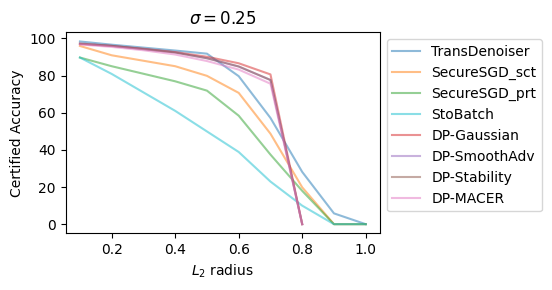

<Figure size 640x480 with 0 Axes>

In [4]:

# dp-augment
key_list = ["DP-Gaussian", "DP-SmoothAdv", "DP-Stability", "DP-MACER"]
# for checkpoint_path in [
#     "/data2/paulwu/robust-dp-label-noise/runs/mnist_*May11*", 
#     ]:
#     if isinstance(checkpoint_path, list):
#         dir_list = checkpoint_path
#     else:
#         dir_list = glob.glob(checkpoint_path)
    
# dir_list = ['/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment_resnet9_sgd_lr_0.25_bsz_256_clip_bound_0.1_sigma_1.259765625May11_16-42-41', 
#             '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-adv-smooth_resnet9_sgd_lr_0.25_bsz_256_clip_bound_0.1_sigma_1.259765625_pgd_steps_2_no_grad_False_max_norm_64_num_augmentations_2_augment_noise_std_0.25May11_17-03-29',
#             '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment_resnet9_sgd_lr_0.25_bsz_256_clip_bound_0.1_sigma_1.259765625_trades_TrueMay11_16-56-52', 
#             '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment_resnet9_sgd_lr_0.25_bsz_256_clip_bound_0.1_sigma_1.259765625_macer_TrueMay11_16-43-18', 
#             ]

dir_list = [
    "runs/mnist_dpsgd-adv-smooth_crossvit_tiny_240.in1k_adam_lr_0.0005_bsz_256_clip_bound_0.1_sigma_1.259765625_pgd_steps_2_no_grad_False_max_norm_64_num_augmentations_1_augment_noise_std_0.25May13_21-28-33/",
    "runs/mnist_dpsgd-augment_crossvit_tiny_240.in1k_adam_lr_0.0005_bsz_256_clip_bound_0.1_sigma_1.259765625May13_21-28-14/",
    "runs/mnist_dpsgd-augment_crossvit_tiny_240.in1k_adam_lr_0.0005_bsz_256_clip_bound_0.1_sigma_1.259765625_macer_TrueMay13_21-28-21/",
    "runs/mnist_dpsgd-augment_crossvit_tiny_240.in1k_adam_lr_0.0005_bsz_256_clip_bound_0.1_sigma_1.259765625_trades_TrueMay13_21-28-27/",
    # "runs/cifar10_dpsgd-augment_crossvit_tiny_240.in1k_adam_lr_0.0005_bsz_512_clip_bound_0.1_sigma_1.6796875May11_19-11-06/",
    # "runs/cifar10_dpsgd-adv-smooth_crossvit_tiny_240.in1k_adam_lr_0.0005_bsz_512_clip_bound_0.1_sigma_1.6796875_pgd_steps_2_no_grad_False_max_norm_64_num_augmentations_1_augment_noise_std_0.25May11_19-10-45/",
    # "runs/cifar10_dpsgd-augment_crossvit_tiny_240.in1k_adam_lr_0.0005_bsz_512_clip_bound_0.1_sigma_1.6796875_trades_TrueMay11_19-11-11/",
    # "runs/cifar10_dpsgd-augment_crossvit_tiny_240.in1k_adam_lr_0.0005_bsz_512_clip_bound_0.1_sigma_1.6796875_macer_TrueMay11_19-11-10/",
]



test_result_df_dict = {}
metric_dict = defaultdict(dict)
noise_std_list = []
print(dir_list)
for j, dir in enumerate(dir_list):
    # print(dir)
    dir = "/data2/paulwu/robust-dp-label-noise/" + dir
    with open(os.path.join(dir, "config.json"), "r") as f:
        cfg = json.load(f)
    
    method = cfg['method']
    if cfg['method'] in ["dpsgd-auto-clip-adv-smooth", "dpsgd-augment-auto-clip"]:
        method += f"_psac_{cfg['psac']}"
    augment_noise_std = cfg["augment_noise_std"]
    num_augmentations = cfg['num_augmentations']
    if num_augmentations != 1:
        continue

    noise_std_list.append(augment_noise_std)

    test_result_df = pd.read_json(os.path.join(dir, "test_results.json"))
    test_result_df_dict[key_list[j]] = test_result_df
    num_correct_at_radius = len(test_result_df[test_result_df['correct'] == True])
    accuracy = num_correct_at_radius / len(test_result_df)

    metric_dict["dataset"][j] = cfg['dataset']
    metric_dict["method"][j] = method
    metric_dict["noise_std"][j] = augment_noise_std
    metric_dict["num_augmentation"][j] = num_augmentations
    metric_dict["accuracy"][j] = accuracy * 100
    
    # for sigma in [0.25, 0.5, 1.0]:
    sigma = augment_noise_std
    radius = test_result_df[f'certified_radius_{sigma}']
    correct = test_result_df[f'certified_correct_{sigma}']
    pred = test_result_df[f'certified_pred_{sigma}']
    certified_accuracy = len(test_result_df[correct == True]) / len(test_result_df)
    # metric_dict[f"certified_accuracy_{sigma}"][j] = certified_accuracy
    # metric_dict[sigma][j] = round(np.mean(radius), 3)
    metric_dict[sigma][j] = round(np.sum(test_result_df[correct == True][f'certified_radius_{sigma}']) / len(test_result_df), 3)
    # if sigma == augment_noise_std:
    #     certified_radius_dict[sigma][cur_key] = round(`np.mean(radius), 3)
            
acc_df = pd.DataFrame(metric_dict)
print(acc_df)
sigma_results = read_certified_robustness_results(key_list, test_result_df_dict)
print(sigma_results)

plt.figure(figsize=(4, 3))

# x = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
x = [0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
for y, name in zip([
    # [48.53, 39.76, 30.76, 22.12, 13.96, 7.74, 2.74, 0],
    # [41.1, 33.1, 24.08, 18.81, 10.8, 5.56, 1.41, 0],
    # [36.26, 29.9, 23.23, 17.86, 11.77, 6.04, 1.77, 0],
    # [28, 20.33, 14.73, 10.82, 7.64, 4.1, 0.89, 0]
    [98.33, 96.6, 93.45, 91.76, 79.65, 57.18, 28.13, 5.82, 0],
    [95.91, 90.89, 85.01, 79.83, 70.66, 48.7, 19.83, 0, 0],
    [89.68, 85.01, 76.89, 71.87, 58.39, 37.46, 17.93, 0, 0],
    [89.68, 80.86, 60.98, 49.91, 38.85, 22.94, 9.97, 0, 0],
],[
    "TransDenoiser",
    "SecureSGD_sct",
    "SecureSGD_prt",
    "StoBatch",
]):
    if name == "StoBatch":
        plt.plot(x, y, alpha=0.5, label=name, color='#17becf')
    else:
        plt.plot(x, y, alpha=0.5, label=name)

end_radius = 0.9
noise_std = 0.25
end_index = int(end_radius / 0.1)
for key in key_list:
    avg = pd.DataFrame.from_dict(sigma_results[noise_std][key]).iloc[0].head(end_index).iloc[1:]
    print(avg.to_list())

    plt.plot(avg, alpha=0.5, label=key)

# [48.53, 39.76, 30.76, 22.12, 13.96, 7.74, 2.74, 0]
# [41.1, 33.1, 24.08, 18.81, 10.8, 5.56, 1.41, 0]
# [36.26, 29.9, 23.23, 17.86, 11.77, 6.04, 1.77, 0]
# [28, 20.33, 14.73, 10.82, 7.64, 4.1, 8.91, 0]

plt.xlabel("$L_2$ radius")
plt.title(f"$\sigma={noise_std}$")
plt.ylabel("Certified Accuracy")

plt.tight_layout()

# plt.rcParams['text.usetex'] = False
plt.legend(bbox_to_anchor=(1, 1))
# plt.legend()
plt.show()
plt.clf()

# print(plt.rcParams['axes.prop_cycle'].by_key()['color'])





In [17]:

# dp-augment
for checkpoint_path in [
    # "/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23Apr16*", 
    # "/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15Apr16*", 
    "/data2/paulwu/robust-dp-label-noise/runs/cifar10_dpsgd-augment_crossvit_tiny_240.in1k_adam_lr_0.001_bsz_1024_clip_bound_0.1_sigma_1.09619140625May05_2*",
    ]:
    if isinstance(checkpoint_path, list):
        dir_list = checkpoint_path
    else:
        dir_list = glob.glob(checkpoint_path)
    print(dir_list)

    acc_df, key_list, test_result_df_dict, noise_std_list = get_acc_df(dir_list, 1)
    sigma_results = read_certified_robustness_results(key_list, test_result_df_dict)
    print(sigma_results)
    print(acc_df)

    # for key in key_list:
    #     for sigma in [0.25, 0.5, 1.0]:
    #         print(f"{key} sigma={sigma}")
    #         avg = pd.DataFrame.from_dict(sigma_results[sigma][key]).iloc[0].tolist()
    #         print(avg)

['/data2/paulwu/robust-dp-label-noise/runs/cifar10_dpsgd-augment_crossvit_tiny_240.in1k_adam_lr_0.001_bsz_1024_clip_bound_0.1_sigma_1.09619140625May05_21-06-08', '/data2/paulwu/robust-dp-label-noise/runs/cifar10_dpsgd-augment_crossvit_tiny_240.in1k_adam_lr_0.001_bsz_1024_clip_bound_0.1_sigma_1.09619140625May05_22-13-17', '/data2/paulwu/robust-dp-label-noise/runs/cifar10_dpsgd-augment_crossvit_tiny_240.in1k_adam_lr_0.001_bsz_1024_clip_bound_0.1_sigma_1.09619140625May05_23-18-52']
defaultdict(<function read_certified_robustness_results.<locals>.<lambda> at 0x7fb95f869c60>, {0.25: defaultdict(<class 'dict'>, {'cifar10_dpsgd-augment_noise_std_0.25_num_aug_1': {0.0: {'certified_acc': 64.4}, 0.1: {'certified_acc': 55.5}, 0.2: {'certified_acc': 46.7}, 0.30000000000000004: {'certified_acc': 37.5}, 0.4: {'certified_acc': 28.8}, 0.5: {'certified_acc': 21.2}, 0.6000000000000001: {'certified_acc': 14.6}, 0.7000000000000001: {'certified_acc': 8.5}, 0.8: {'certified_acc': 0.0}, 0.9: {'certified_acc'

In [60]:

# dp-adv-smooth training
checkpoint_paths = [
    '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-adv-smooth*Apr1[78]*',
    '/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-adv-smooth*Apr1[78]*',
]
for checkpoint_path in checkpoint_paths:
    # print(checkpoint_path)
    dir_list = glob.glob(checkpoint_path)
    print(dir_list)
    
    acc_df, key_list, test_result_df_dict, noise_std_list = get_acc_df(dir_list)
    sigma_results = read_certified_robustness_results(key_list, test_result_df_dict)
    print(acc_df.to_string())
    # print(pd.DataFrame(certified_radius_dict).to_string())

    # for key, augment_noise_std in zip(key_list, noise_std_list):
    #     for sigma in [0.25, 0.5, 1.0]:
    #         if augment_noise_std == sigma:
    #             print(f"{key} sigma={sigma}")
    #             avg = pd.DataFrame.from_dict(sigma_results[sigma][key]).iloc[0].tolist()
    #             print(avg)



['/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-adv-smooth_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23_pgd_steps_2_no_grad_False_max_norm_64_num_augmentations_4_augment_noise_std_0.12Apr18_15-04-54', '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-adv-smooth_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23_pgd_steps_2_no_grad_False_max_norm_64_num_augmentations_2_augment_noise_std_1.0Apr17_16-19-23', '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-adv-smooth_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23_pgd_steps_2_no_grad_False_max_norm_64_num_augmentations_4_augment_noise_std_1.0Apr17_16-34-13', '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-adv-smooth_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23_pgd_steps_2_no_grad_False_max_norm_64_num_augmentations_6_augment_noise_std_1.0Apr17_16-51-50', '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-adv-smooth_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23_pgd_steps_2_no_grad_False_max_norm_64_num_au

In [45]:
# stability training
checkpoint_paths = [
    '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment*Apr22*',
    '/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment*Apr22*',
    # trade_list
]
for checkpoint_path in checkpoint_paths:
    if isinstance(checkpoint_path, list):
        dir_list = checkpoint_path
    else:
        dir_list = glob.glob(checkpoint_path)

    acc_df, key_list, test_result_df_dict, noise_std_list = get_acc_df(dir_list)
    sigma_results = read_certified_robustness_results(key_list, test_result_df_dict)
    print(acc_df)

    # for key in key_list:
    #     for sigma in [0.25, 0.5, 1.0]:
    #         print(f"{key} sigma={sigma}")
    #         avg = pd.DataFrame.from_dict(sigma_results[sigma][key]).iloc[0].tolist()
    #         print(avg)

  dataset         method  noise_std  num_augmentation  accuracy   0.25    0.5  \
0   mnist  dpsgd-augment       0.50                 2     97.62  0.745  1.248   
1   mnist  dpsgd-augment       0.25                 2     97.86  0.738  1.036   
2   mnist  dpsgd-augment       0.12                 2     97.88  0.703  0.656   
3   mnist  dpsgd-augment       1.00                 2     96.48  0.731  1.257   

     1.0  
0  0.908  
1  0.458  
2  0.253  
3  1.262  
         dataset         method  noise_std  num_augmentation  accuracy   0.25  \
0  fashion-mnist  dpsgd-augment       0.50                 2     82.25  0.556   
1  fashion-mnist  dpsgd-augment       0.12                 2     84.77  0.503   
2  fashion-mnist  dpsgd-augment       0.25                 2     84.19  0.551   
3  fashion-mnist  dpsgd-augment       1.00                 2     80.66  0.544   

     0.5    1.0  
0  0.876  0.825  
1  0.500  0.313  
2  0.749  0.465  
3  0.898  1.084  


In [43]:
# macer training
checkpoint_paths = [
    '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment*Apr21_1[67]*',
    '/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment*Apr21_1[67]*',
    # macer_list
]
for checkpoint_path in checkpoint_paths:
    if isinstance(checkpoint_path, list):
        dir_list = checkpoint_path
    else:
        dir_list = glob.glob(checkpoint_path)

    acc_df, key_list, test_result_df_dict, noise_std_list = get_acc_df(dir_list)
    sigma_results = read_certified_robustness_results(key_list, test_result_df_dict)
    print(acc_df)

    # for key in key_list:
    #     for sigma in [0.25, 0.5, 1.0]:
    #         print(f"{key} sigma={sigma}")
    #         avg = pd.DataFrame.from_dict(sigma_results[sigma][key]).iloc[0].tolist()
    #         print(avg)



  dataset         method  noise_std  num_augmentation  accuracy   0.25    0.5  \
0   mnist  dpsgd-augment       0.12                 2     98.13  0.702  0.629   
1   mnist  dpsgd-augment       0.25                 2     98.13  0.736  1.010   
2   mnist  dpsgd-augment       0.50                 2     97.75  0.746  1.246   
3   mnist  dpsgd-augment       1.00                 2     96.31  0.732  1.266   

     1.0  
0  0.233  
1  0.388  
2  0.864  
3  1.262  
         dataset         method  noise_std  num_augmentation  accuracy   0.25  \
0  fashion-mnist  dpsgd-augment       0.12                 2     85.25  0.494   
1  fashion-mnist  dpsgd-augment       0.25                 2     84.79  0.545   
2  fashion-mnist  dpsgd-augment       0.50                 2     82.50  0.558   
3  fashion-mnist  dpsgd-augment       1.00                 2     80.83  0.544   

     0.5    1.0  
0  0.551  0.389  
1  0.735  0.505  
2  0.880  0.840  
3  0.899  1.102  


In [3]:
# dp auto clip training
checkpoint_paths = [
    '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment-auto-clip_cnn*',
    '/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment-auto-clip_cnn*',
    # '/data2/paulwu/robust-dp-label-noise/runs/cifar10_dpsgd-augment-auto-clip*',
]
for checkpoint_path in checkpoint_paths:
    if isinstance(checkpoint_path, list):
        dir_list = checkpoint_path
    else:
        dir_list = glob.glob(checkpoint_path)
    
    acc_df, key_list, test_result_df_dict, noise_std_list = get_acc_df(dir_list)
    sigma_results = read_certified_robustness_results(key_list, test_result_df_dict)
    
    # print(acc_df)
    print(acc_df[acc_df['method'] == "dpsgd-augment-auto-clip_psac_True"])

    # for key in key_list:
    #     for sigma in [0.25, 0.5, 1.0]:
    #         print(f"{key} σ={sigma}")
    #         avg = pd.DataFrame.from_dict(sigma_results[sigma][key]).iloc[0].tolist()
    #         print(avg)




  dataset                             method  noise_std  num_augmentation  \
0   mnist  dpsgd-augment-auto-clip_psac_True       0.12                 2   
2   mnist  dpsgd-augment-auto-clip_psac_True       0.25                 2   
4   mnist  dpsgd-augment-auto-clip_psac_True       0.50                 2   
6   mnist  dpsgd-augment-auto-clip_psac_True       1.00                 2   

   accuracy   0.25    0.5    1.0  
0     98.16  0.699  0.621  0.234  
2     98.12  0.734  0.998  0.380  
4     97.74  0.746  1.240  0.851  
6     96.44  0.733  1.267  1.257  
         dataset                             method  noise_std  \
0  fashion-mnist  dpsgd-augment-auto-clip_psac_True       0.12   
2  fashion-mnist  dpsgd-augment-auto-clip_psac_True       0.25   
4  fashion-mnist  dpsgd-augment-auto-clip_psac_True       0.50   
6  fashion-mnist  dpsgd-augment-auto-clip_psac_True       1.00   

   num_augmentation  accuracy   0.25    0.5    1.0  
0                 2     85.37  0.491  0.546  0.386  
2 

In [4]:
# consistency training
checkpoint_paths = [
    '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment*Apr20*',
    '/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment*Apr20*',
    # consistency_list
]
for checkpoint_path in checkpoint_paths:
    if isinstance(checkpoint_path, list):
        dir_list = checkpoint_path
    else:
        dir_list = glob.glob(checkpoint_path)

    acc_df, key_list, test_result_df_dict, noise_std_list = get_acc_df(dir_list)
    sigma_results = read_certified_robustness_results(key_list, test_result_df_dict)
    print(acc_df)

    # for key in key_list:
    #     for sigma in [0.25, 0.5, 1.0]:
    #         print(f"{key} sigma={sigma}")
    #         avg = pd.DataFrame.from_dict(sigma_results[sigma][key]).iloc[0].tolist()
    #         print(avg)



  dataset         method  noise_std  num_augmentation  accuracy   0.25    0.5  \
0   mnist  dpsgd-augment       0.25                 2     97.73  0.736  1.036   
1   mnist  dpsgd-augment       0.12                 2     97.91  0.701  0.657   
2   mnist  dpsgd-augment       0.50                 2     97.33  0.743  1.239   
3   mnist  dpsgd-augment       1.00                 2     96.34  0.729  1.253   

     1.0  
0  0.467  
1  0.229  
2  0.913  
3  1.252  
         dataset         method  noise_std  num_augmentation  accuracy   0.25  \
0  fashion-mnist  dpsgd-augment       0.12                 2     84.85  0.503   
1  fashion-mnist  dpsgd-augment       0.25                 2     84.34  0.545   
2  fashion-mnist  dpsgd-augment       0.50                 2     82.50  0.557   
3  fashion-mnist  dpsgd-augment       1.00                 2     81.04  0.544   

     0.5    1.0  
0  0.506  0.324  
1  0.736  0.434  
2  0.869  0.819  
3  0.899  1.092  


In [5]:

# dp-adv-smooth-psac training
checkpoint_paths = [
    '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-auto-clip-adv-smooth*psac_True*Apr1[78]*',
    '/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-auto-clip-adv-smooth*psac_True*Apr1[78]*',
]
for checkpoint_path in checkpoint_paths:
    print(checkpoint_path)
    dir_list = glob.glob(checkpoint_path)
    
    acc_df, key_list, test_result_df_dict, noise_std_list = get_acc_df(dir_list)
    sigma_results = read_certified_robustness_results(key_list, test_result_df_dict)
    print(acc_df.to_string())
    # print(pd.DataFrame(certified_radius_dict).to_string())
    # for key, augment_noise_std in zip(key_list, noise_std_list):
    #     for sigma in [0.25, 0.5, 1.0]:
    #         if augment_noise_std == sigma:
    #             print(f"{key} sigma={sigma}")
    #             avg = pd.DataFrame.from_dict(sigma_results[sigma][key]).iloc[0].tolist()
    #             print(avg)


/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-auto-clip-adv-smooth*psac_True*Apr1[78]*
  dataset                                method  noise_std  num_augmentation  accuracy   0.25    0.5    1.0
0   mnist  dpsgd-auto-clip-adv-smooth_psac_True       1.00                 2     96.59  0.734  1.266  1.246
5   mnist  dpsgd-auto-clip-adv-smooth_psac_True       0.12                 2     98.16  0.714  0.605  0.238
6   mnist  dpsgd-auto-clip-adv-smooth_psac_True       0.25                 2     98.05  0.741  1.024  0.369
7   mnist  dpsgd-auto-clip-adv-smooth_psac_True       0.50                 2     97.63  0.746  1.252  0.859
/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-auto-clip-adv-smooth*psac_True*Apr1[78]*
         dataset                                method  noise_std  num_augmentation  accuracy   0.25    0.5    1.0
0  fashion-mnist  dpsgd-auto-clip-adv-smooth_psac_True       1.00                 2     81.13  0.545  0.894  1.091
4  fashion-mnist  dpsgd-auto-clip-

In [7]:

# dp-adv-smooth with consistency
checkpoint_paths = [
    "/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-adv-smooth*Apr20*",
    "/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-adv-smooth*Apr20*",
]
for checkpoint_path in checkpoint_paths:
    print(checkpoint_path)
    dir_list = glob.glob(checkpoint_path)
    
    acc_df, key_list, test_result_df_dict, noise_std_list = get_acc_df(dir_list)
    sigma_results = read_certified_robustness_results(key_list, test_result_df_dict)
    print(acc_df.to_string())
    
    # for key, augment_noise_std in zip(key_list, noise_std_list):
    #     for sigma in [0.25, 0.5, 1.0]:
    #         if augment_noise_std == sigma:
    #             print(f"{key} sigma={sigma}")
    #             avg = pd.DataFrame.from_dict(sigma_results[sigma][key]).iloc[0].tolist()
    #             print(avg)

/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-adv-smooth*Apr20*
  dataset            method  noise_std  num_augmentation  accuracy   0.25    0.5    1.0
0   mnist  dpsgd-adv-smooth       0.50                 2     97.29  0.742  1.252  0.937
1   mnist  dpsgd-adv-smooth       0.12                 2     98.00  0.722  0.707  0.240
2   mnist  dpsgd-adv-smooth       0.25                 2     97.76  0.740  1.089  0.456
3   mnist  dpsgd-adv-smooth       1.00                 2     96.33  0.729  1.247  1.240
/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-adv-smooth*Apr20*
         dataset            method  noise_std  num_augmentation  accuracy   0.25    0.5    1.0
0  fashion-mnist  dpsgd-adv-smooth       0.25                 2     83.46  0.553  0.729  0.474
1  fashion-mnist  dpsgd-adv-smooth       0.12                 2     84.66  0.510  0.472  0.337
2  fashion-mnist  dpsgd-adv-smooth       0.50                 2     81.92  0.558  0.884  0.830
3  fashion-mnist  dpsgd-adv-sm

In [64]:

# augmentation = 8 training
checkpoint_paths = [
    "/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23Apr29*",
    "/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-adv-smooth_cnn*Apr29*",
    # "/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment*consistency_True*Apr29*",
    "/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment*trades_True*Apr29*",
    "/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment*macer_True*Apr29*",

    "/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15Apr29*",
    "/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-adv-smooth_cnn*Apr29*",
    "/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment*trades_True*Apr29*",
    "/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment*macer_True*Apr29*",
]
for checkpoint_path in checkpoint_paths:
    dir_list = glob.glob(checkpoint_path)
    
    acc_df, key_list, test_result_df_dict, noise_std_list = get_acc_df(dir_list, 8)
    sigma_results = read_certified_robustness_results(key_list, test_result_df_dict)
    print(acc_df.to_string())
    # print(pd.DataFrame(certified_radius_dict).to_string())

    for key, augment_noise_std in zip(key_list, noise_std_list):
        for sigma in [0.25, 0.5, 1.0]:
            if augment_noise_std == sigma:
                print(f"{key} sigma={sigma}")
                avg = pd.DataFrame.from_dict(sigma_results[sigma][key]).iloc[0].tolist()
                print(avg)



  dataset         method  noise_std  num_augmentation  accuracy   0.25    0.5    1.0
0   mnist  dpsgd-augment       0.25                 8     98.09  0.745  1.041  0.342
1   mnist  dpsgd-augment       0.50                 8     97.74  0.752  1.295  0.857
2   mnist  dpsgd-augment       1.00                 8     95.59  0.725  1.269  1.354
mnist_dpsgd-augment_noise_std_0.25_num_aug_8 sigma=0.25
[98.0, 97.5, 96.7, 95.6, 94.3, 92.8, 90.8, 87.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
mnist_dpsgd-augment_noise_std_0.5_num_aug_8 sigma=0.5
[97.0, 96.6, 95.6, 94.7, 93.8, 92.7, 91.3, 89.4, 87.0, 84.1, 81.3, 77.4, 72.6, 66.3, 58.8, 49.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
mnist_dpsgd-augment_noise_std_1.0_num_aug_8 sigma=1.0
[90.3, 88.8, 87.2, 85.0, 82.7, 80.1, 77.5, 74.6, 71.6, 68.0, 64.6, 60.9, 56.9, 53.2, 49.3, 45.6, 42.2, 38.2, 34.2, 29.8, 26.0, 21.8, 18.1, 14.3, 10.9]
  dataset            method  noise_std  num_augmentation  accuracy   

In [20]:

# get cifar config list
dir_list = glob.glob("/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-adv-smooth*Apr20*")
trade_list = []
macer_list = []
consistency_list = []
vanilla_list = []
for j, dir in enumerate(dir_list):
    with open(os.path.join(dir, "config.json"), "r") as f:
        cfg = json.load(f)
    print(dir)
    if "consistency" in cfg and cfg["consistency"]:
        print("consistency")
    # if cfg["trades"]:
    #     trade_list.append(dir)
    # elif cfg["macer"]:
    #     macer_list.append(dir)
    # elif cfg["consistency"]:
    #     consistency_list.append(dir)
    # else:
    #     vanilla_list.append(dir)


/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-adv-smooth_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23_pgd_steps_2_no_grad_False_max_norm_64_num_augmentations_2_augment_noise_std_0.5Apr20_22-19-08
consistency
/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-adv-smooth_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23_pgd_steps_2_no_grad_False_max_norm_64_num_augmentations_2_augment_noise_std_0.12Apr20_21-52-29
consistency
/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-adv-smooth_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23_pgd_steps_2_no_grad_False_max_norm_64_num_augmentations_2_augment_noise_std_0.25Apr20_22-06-44
consistency
/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-adv-smooth_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23_pgd_steps_2_no_grad_False_max_norm_64_num_augmentations_2_augment_noise_std_1.0Apr20_22-32-28
consistency


In [8]:
def pipeline(dir_list):
    test_result_df_dict = {}
    metric_dict = defaultdict(dict)
    key_list = []
    noise_std_list = []
    for j, dir in enumerate(dir_list):
        # print(dir)
        with open(os.path.join(dir, "config.json"), "r") as f:
            cfg = json.load(f)
        
        method = cfg['method']
        if cfg['method'] in ["dpsgd-auto-clip-adv-smooth", "dpsgd-augment-auto-clip"]:
            method += f"_psac_{cfg['psac']}"
        augment_noise_std = cfg["augment_noise_std"]
        num_augmentations = cfg['num_augmentations']
        if num_augmentations != 2:
            continue

        # cur_key = f"{cfg['dataset']}_{method}_noise_std_{augment_noise_std}_num_aug_{num_augmentations}"
        cur_key = dir
        key_list.append(cur_key)
        noise_std_list.append(augment_noise_std)

        test_result_df = pd.read_json(os.path.join(dir, "test_results.json"))
        test_result_df_dict[cur_key] = test_result_df
        num_correct_at_radius = len(test_result_df[test_result_df['correct'] == True])
        accuracy = num_correct_at_radius / len(test_result_df)

        metric_dict["dataset"][j] = cfg['dataset']
        metric_dict["method"][j] = method
        metric_dict["noise_std"][j] = augment_noise_std
        metric_dict["num_augmentation"][j] = num_augmentations
        metric_dict["accuracy"][j] = accuracy * 100
        # print(augment_noise_std)
        # print(test_result_df.columns)
        sigma = augment_noise_std

        radius = test_result_df[f'certified_radius_{sigma}']
        correct = test_result_df[f'certified_correct_{sigma}']
        pred = test_result_df[f'certified_pred_{sigma}']
        certified_accuracy = len(test_result_df[correct == True]) / len(test_result_df)
        # metric_dict[f"certified_accuracy_{sigma}"][j] = certified_accuracy
        # metric_dict[sigma][j] = round(np.mean(radius), 3)
        metric_dict[sigma][j] = round(np.sum(test_result_df[correct == True][f'certified_radius_{sigma}']) / len(test_result_df), 3)
    acc_df = pd.DataFrame(metric_dict)
    print(acc_df.to_string())

    sigma_results = defaultdict(lambda: defaultdict(dict))
    for key, noise_std in zip(key_list, noise_std_list):
        # for sigma in [0.25, 0.5, 1.0]:
        test_result_df = test_result_df_dict[key]
        # print(test_result_df)
        cert_radius = test_result_df[f'certified_radius_{noise_std}']
        correct = test_result_df[f'certified_correct_{noise_std}']
        pred = test_result_df[f'certified_pred_{noise_std}']
        # different_radius = []
        for radius in np.arange(0.0, noise_std_to_end_radius[noise_std], 0.25):
            num_correct_at_radius = ((correct == True) & (cert_radius >= radius)).mean()
            sigma_results[noise_std][key][radius] = {'certified_acc': round(100 * num_correct_at_radius, 1)}
    return acc_df, key_list, test_result_df_dict, noise_std_list, sigma_results

# dp-adv-smooth with consistency
checkpoint_paths = [
    "/data2/paulwu/robust-dp-label-noise/runs/cifar10_dpsgd-augment_crossvit_tiny_240.in1k_adam_lr_0.001_bsz_1024_clip_bound_0.1_sigma_1.09619140625May05_2*",
    # "/data2/paulwu/robust-dp-label-noise/runs/cifar10_dpsgd-augment_crossvit_tiny_240.in1k_adam_lr_0.002_bsz_1024_clip_bound_0.1_sigma_0.9228515625May02*",
]
noise_std_to_end_radius = {0.25: 1.2, 0.5: 2.1, 1.0: 4.1}
for checkpoint_path in checkpoint_paths:
    print(checkpoint_path)
    dir_list = glob.glob(checkpoint_path)
    acc_df, key_list, test_result_df_dict, noise_std_list, sigma_results = pipeline(dir_list)
    
    for key, augment_noise_std in zip(key_list, noise_std_list):
        print(f"{key} sigma={augment_noise_std}")
        avg = pd.DataFrame.from_dict(sigma_results[augment_noise_std][key]).iloc[0].tolist()
        print(avg)

/data2/paulwu/robust-dp-label-noise/runs/cifar10_dpsgd-augment_crossvit_tiny_240.in1k_adam_lr_0.001_bsz_1024_clip_bound_0.1_sigma_1.09619140625May05_2*
Empty DataFrame
Columns: []
Index: []


In [9]:
# adv smoothing
checkpoint_paths = [
    "/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-adv-smooth_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23_pgd_steps_2_no_grad_False_max_norm_64_num_augmentations_2_augment_noise_std_0.25May17_20-37*",
]
for checkpoint_path in checkpoint_paths:
    print(checkpoint_path)
    dir_list = glob.glob(checkpoint_path)
    acc_df, key_list, test_result_df_dict, noise_std_list, sigma_results = pipeline(dir_list)
    for key, augment_noise_std in zip(key_list, noise_std_list):
        print(f"{key} sigma={augment_noise_std}")
        avg = pd.DataFrame.from_dict(sigma_results[augment_noise_std][key]).iloc[0].tolist()
        print(avg)

/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-adv-smooth_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23_pgd_steps_2_no_grad_False_max_norm_64_num_augmentations_2_augment_noise_std_0.25May17_20-37*
  dataset            method  noise_std  num_augmentation  accuracy  0.25
0   mnist  dpsgd-adv-smooth       0.25                 2     98.01  0.74
/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-adv-smooth_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23_pgd_steps_2_no_grad_False_max_norm_64_num_augmentations_2_augment_noise_std_0.25May17_20-37-05 sigma=0.25
[97.9, 95.9, 92.4, 84.2, 0.0]


In [ ]:

checkpoint_paths = [
    "/data2/paulwu/robust-dp-label-noise/runs/cifar10_dpsgd-adv-smooth_crossvit_tiny_240.in1k_adam_lr_0.001*",
]
for checkpoint_path in checkpoint_paths:
    print(checkpoint_path)
    dir_list = glob.glob(checkpoint_path)
    acc_df, key_list, test_result_df_dict, noise_std_list, sigma_results = pipeline(dir_list)
    for key, augment_noise_std in zip(key_list, noise_std_list):
        print(f"{key} sigma={augment_noise_std}")
        avg = pd.DataFrame.from_dict(sigma_results[augment_noise_std][key]).iloc[0].tolist()
        print(avg)

In [31]:
# stability
checkpoint_paths = [
    "/data2/paulwu/robust-dp-label-noise/runs/cifar10_dpsgd-augment_crossvit_tiny_240.in1k_adam_lr_0.001_bsz_1024_clip_bound_0.1_sigma_1.09619140625_trades_True*",
]
for checkpoint_path in checkpoint_paths:
    print(checkpoint_path)
    dir_list = glob.glob(checkpoint_path)
    acc_df, key_list, test_result_df_dict, noise_std_list, sigma_results = pipeline(dir_list)

    for key, augment_noise_std in zip(key_list, noise_std_list):
        print(f"{key} sigma={augment_noise_std}")
        avg = pd.DataFrame.from_dict(sigma_results[augment_noise_std][key]).iloc[0].tolist()
        print(avg)
    

/data2/paulwu/robust-dp-label-noise/runs/cifar10_dpsgd-augment_crossvit_tiny_240.in1k_adam_lr_0.001_bsz_1024_clip_bound_0.1_sigma_1.09619140625_trades_True*
   dataset         method  noise_std  num_augmentation  accuracy   0.25    0.5    1.0
0  cifar10  dpsgd-augment       0.25                 1     88.53  0.246    NaN    NaN
1  cifar10  dpsgd-augment       0.50                 1     88.56    NaN  0.282    NaN
2  cifar10  dpsgd-augment       1.00                 1     89.09    NaN    NaN  0.294
/data2/paulwu/robust-dp-label-noise/runs/cifar10_dpsgd-augment_crossvit_tiny_240.in1k_adam_lr_0.001_bsz_1024_clip_bound_0.1_sigma_1.09619140625_trades_TrueMay05_21-08-14 sigma=0.25
[63.7, 41.6, 21.2, 6.7, 0.0]
/data2/paulwu/robust-dp-label-noise/runs/cifar10_dpsgd-augment_crossvit_tiny_240.in1k_adam_lr_0.001_bsz_1024_clip_bound_0.1_sigma_1.09619140625_trades_TrueMay05_22-19-40 sigma=0.5
[46.9, 35.4, 24.7, 15.4, 9.0, 4.3, 1.6, 0.0, 0.0]
/data2/paulwu/robust-dp-label-noise/runs/cifar10_dpsgd-augm

In [25]:

# macer
checkpoint_paths = [
    "/data2/paulwu/robust-dp-label-noise/runs/cifar10_dpsgd-augment_crossvit_tiny_240.in1k_adam_lr_0.001_bsz_1024_clip_bound_0.1_sigma_1.09619140625_macer_True*",
]
for checkpoint_path in checkpoint_paths:
    dir_list = glob.glob(checkpoint_path)
    acc_df, key_list, test_result_df_dict, noise_std_list, sigma_results = pipeline(dir_list)

    for key, augment_noise_std in zip(key_list, noise_std_list):
        print(f"{key} sigma={augment_noise_std}")
        avg = pd.DataFrame.from_dict(sigma_results[augment_noise_std][key]).iloc[0].tolist()
        print(avg)

   dataset         method  noise_std  num_augmentation  accuracy   0.25    0.5    1.0
0  cifar10  dpsgd-augment       0.25                 1     87.52  0.246    NaN    NaN
1  cifar10  dpsgd-augment       0.50                 1     87.36    NaN  0.287    NaN
2  cifar10  dpsgd-augment       1.00                 1     88.40    NaN    NaN  0.255
/data2/paulwu/robust-dp-label-noise/runs/cifar10_dpsgd-augment_crossvit_tiny_240.in1k_adam_lr_0.001_bsz_1024_clip_bound_0.1_sigma_1.09619140625_macer_TrueMay05_21-06-08 sigma=0.25
[64.1, 41.7, 21.1, 6.2, 0.0]
/data2/paulwu/robust-dp-label-noise/runs/cifar10_dpsgd-augment_crossvit_tiny_240.in1k_adam_lr_0.001_bsz_1024_clip_bound_0.1_sigma_1.09619140625_macer_TrueMay05_22-18-16 sigma=0.5
[46.5, 35.2, 24.7, 15.9, 9.8, 5.1, 2.1, 0.0, 0.0]
/data2/paulwu/robust-dp-label-noise/runs/cifar10_dpsgd-augment_crossvit_tiny_240.in1k_adam_lr_0.001_bsz_1024_clip_bound_0.1_sigma_1.09619140625_macer_TrueMay05_23-29-58 sigma=1.0
[28.6, 22.3, 17.2, 13.2, 10.1, 7.5, 5.6

KeyError: 'fgsm_0.0005'

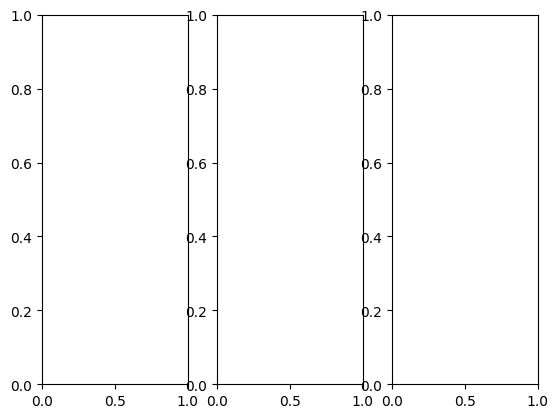

In [62]:
baseline_paths = [
    [
        "/data2/paulwu/robust-dp-label-noise/runs/mnist_regular_cnn_sgd_lr_0.01_bsz_512_clip_bound_0.1_sigma_0.8Mar23_17-57-37",
        "/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23Mar23_17-57-54",
        "/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-auto-clip_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23_psac_TrueMay02_22-45-57",
    ],[
        # "/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_regular_cnn_sgd_lr_0.01_bsz_512_clip_bound_0.1_sigma_0.8Mar30_22-20-58",
        # "/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15Mar30_22-21-12",
        # "/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-auto-clip_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15_psac_TrueMay03_00-42-09",
    ],[
        "/data2/paulwu/robust-dp-label-noise/runs/cifar10_regular_crossvit_tiny_240.in1k_sgd_lr_0.001_bsz_512_clip_bound_0.1_sigma_0.8May05_21-09-07",
        "/data2/paulwu/robust-dp-label-noise/runs/cifar10_dpsgd_crossvit_tiny_240.in1k_adam_lr_0.001_bsz_1024_clip_bound_0.1_sigma_1.09619140625May05_21-34-38",
        "/data2/paulwu/robust-dp-label-noise/runs/cifar10_dpsgd-auto-clip_crossvit_tiny_240.in1k_adam_lr_0.001_bsz_1024_clip_bound_0.1_sigma_1.09619140625_psac_TrueMay05_21-59-55"
    ]
]

checkpoint_paths = [
    [
        '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23Apr16*',
        '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-adv-smooth*num_augmentations_2*Apr1[78]*',
        '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment*Apr22*',
        '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment*Apr21_1[67]*',
    ],
    [
        '/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15Apr16*',
        '/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-adv-smooth*num_augmentations_2*Apr1[78]*',
        '/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment*Apr22*',
        '/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment*Apr21_1[67]*',
    ],[
        '/data2/paulwu/robust-dp-label-noise/runs/cifar10_dpsgd-augment_crossvit_tiny_240.in1k_adam_lr_0.001_bsz_1024_clip_bound_0.1_sigma_1.09619140625May05_2*',
        '/data2/paulwu/robust-dp-label-noise/runs/cifar10_dpsgd-adv-smooth_crossvit_tiny_240.in1k_adam_lr_0.001*',
        '/data2/paulwu/robust-dp-label-noise/runs/cifar10_dpsgd-augment_crossvit_tiny_240.in1k_adam_lr_0.001_bsz_1024_clip_bound_0.1_sigma_1.09619140625_trades_True*',
        '/data2/paulwu/robust-dp-label-noise/runs/cifar10_dpsgd-augment_crossvit_tiny_240.in1k_adam_lr_0.001_bsz_1024_clip_bound_0.1_sigma_1.09619140625_macer_True*',
    ]
]

path_idx = 2
noise_std_dict = defaultdict(list)

for checkpoint_path in checkpoint_paths[path_idx]:
    dir_list = glob.glob(checkpoint_path)
    # print(dir_list)
    for dir in dir_list:
        with open(os.path.join(dir, "config.json"), "r") as f:
            cfg = json.load(f)
        
        augment_noise_std = cfg["augment_noise_std"]
        num_augmentations = cfg['num_augmentations']
        if num_augmentations == 2:
            noise_std_dict[augment_noise_std].append(dir)

# key_list = ["DP-Gaussian", "DP-SmoothAdv", "DP-Stability", "DP-MACER"]
key_list = ["Regular", "DPSGD", "PSAC", "DP-Gaussian", "DP-SmoothAdv", "DP-Stability", "DP-MACER"]
noise_std_to_end_radius = {0.25: 1.2, 0.5: 2.1, 1.0: 4.1}
fig, ax = plt.subplots(1, 3)
matric_to_key_dict = {"hess_eigen_val": "Hessian Eigenvalue", "local_lip": "Local Lipschitz", "input_grad_norm": "Input Grad Norm"}
for i, noise_std in enumerate([0.25, 0.5, 1.0]):
    dir_list = baseline_paths[path_idx] + noise_std_dict[noise_std]
    # print(dir_list)
    test_result_df_dict = {}
    metric_dict = defaultdict(dict)
    
    for j, dir in enumerate(dir_list):
        with open(os.path.join(dir, "config.json"), "r") as f:
            cfg = json.load(f)
        
        method = cfg['method']

        # if "trades" in cfg and cfg["trades"]:
        #     print("stability" + dir)
        # elif "macer" in cfg and cfg["macer"]:
        #     print("macer" + dir)

        cur_key = key_list[j]
        
        test_result_df = pd.read_json(os.path.join(dir, "test_results.json"))
        # print(test_result_df.columns)
        test_result_df_dict[cur_key] = test_result_df
        num_correct_at_radius = len(test_result_df[test_result_df['correct'] == True])
        accuracy = num_correct_at_radius / len(test_result_df)

        metric_dict["method"][j] = cur_key
        metric_dict["accuracy"][j] = accuracy * 100
        num_correct = len(test_result_df[test_result_df['correct'] == True])
        # print(accuracy)
        for sigma in [0.25, 0.5, 1.0]:
            radius = test_result_df[f'certified_radius_{sigma}']
            correct = test_result_df[f'certified_correct_{sigma}']
            pred = test_result_df[f'certified_pred_{sigma}']
            certified_accuracy = len(test_result_df[correct == True]) / len(test_result_df)
            metric_dict[sigma][j] = round(np.mean(radius), 3)
            
        for i in ['fgsm_0.0005', 'fgsm_0.01', 'fgsm_0.1', 'fgsm_0.5', 'fgsm_1']:
            # print(len(test_result_df[test_result_df[i] == 1]))
            robustness_accuracy = len(test_result_df[test_result_df[i] == True]) / num_correct
            metric_dict[i][j] = 1 - robustness_accuracy
    

    # acc_df = pd.DataFrame(metric_dict).sort_values(by="accuracy", ascending=False)
    acc_df = pd.DataFrame(metric_dict)
    sigma_results = read_certified_robustness_results(key_list, test_result_df_dict, end_radius=4.1)
    print(acc_df.to_string())

    end_radius = noise_std_to_end_radius[noise_std]
    end_index = int(end_radius / 0.1)
    for key in key_list:
        avg = pd.DataFrame.from_dict(sigma_results[noise_std][key]).iloc[0].head(end_index)
        ax[i].plot(avg, alpha=0.5, label=key)
    ax[i].set_xlabel("$L_2$ radius")
    ax[i].set_title(f"$\sigma={noise_std}$")
    ax[i].set_ylabel("Certified Accuracy")
    
    
    # adv_accuracies = acc_df[['fgsm_0.0005', 'fgsm_0.01', 'fgsm_0.1', 'fgsm_0.5', 'fgsm_1']]
    # methods = acc_df['method']
    # x = [0.0005, 0.01, 0.1, 0.5, 1]
    # for k in range(len(adv_accuracies)):
    #     avg = (adv_accuracies.iloc[k] * 100).tolist()
    #     ax[i].plot(x, avg, alpha=0.5, label=methods[k])
    #     ax[i].set_xlabel("$L_{inf}$ Attack Strength")
    #     ax[i].set_ylabel("Adversarial Accuracy")
    #     ax[i].set_title(f"$\sigma={noise_std}$")
fig.set_size_inches(11, 3)

plt.tight_layout()

# plt.rcParams['text.usetex'] = False
# plt.legend(loc='center', bbox_to_anchor=(1.05, 2.5), ncol=7)
plt.show()
plt.clf()

         method  accuracy   0.25    0.5    1.0
0       Regular     94.79  0.271  0.742  0.719
1         DPSGD     89.74  0.112  0.529  0.278
2          PSAC     89.81  0.096  0.524  0.220
3   DP-Gaussian     87.61  0.280    NaN    NaN
4  DP-SmoothAdv     87.89  0.333    NaN    NaN
5  DP-Stability     88.53  0.281    NaN    NaN
6      DP-MACER     87.52  0.280    NaN    NaN
         method  accuracy   0.25    0.5    1.0
0       Regular     94.79  0.271  0.742  0.719
1         DPSGD     89.74  0.112  0.529  0.278
2          PSAC     89.81  0.096  0.524  0.220
3   DP-Gaussian     87.48    NaN  0.378    NaN
4  DP-SmoothAdv     87.54    NaN  0.376    NaN
5  DP-Stability     88.56    NaN  0.371    NaN
6      DP-MACER     87.36    NaN  0.380    NaN
         method  accuracy   0.25    0.5    1.0
0       Regular     94.79  0.271  0.742  0.719
1         DPSGD     89.74  0.112  0.529  0.278
2          PSAC     89.81  0.096  0.524  0.220
3   DP-Gaussian     88.55    NaN    NaN  0.530
4  DP-SmoothA

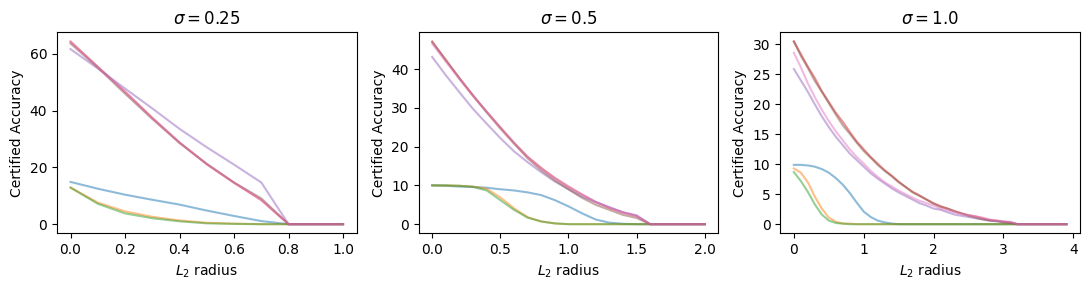

<Figure size 640x480 with 0 Axes>

In [21]:
baseline_paths = [
    [
        "/data2/paulwu/robust-dp-label-noise/runs/mnist_regular_cnn_sgd_lr_0.01_bsz_512_clip_bound_0.1_sigma_0.8Mar23_17-57-37",
        "/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23Mar23_17-57-54",
        "/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-auto-clip_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23_psac_TrueMay02_22-45-57",
    ],[
        # "/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_regular_cnn_sgd_lr_0.01_bsz_512_clip_bound_0.1_sigma_0.8Mar30_22-20-58",
        # "/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15Mar30_22-21-12",
        # "/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-auto-clip_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15_psac_TrueMay03_00-42-09",
    ],[
        "/data2/paulwu/robust-dp-label-noise/runs/cifar10_regular_crossvit_tiny_240.in1k_sgd_lr_0.001_bsz_512_clip_bound_0.1_sigma_0.8May05_21-09-07",
        "/data2/paulwu/robust-dp-label-noise/runs/cifar10_dpsgd_crossvit_tiny_240.in1k_adam_lr_0.001_bsz_1024_clip_bound_0.1_sigma_1.09619140625May05_21-34-38",
        "/data2/paulwu/robust-dp-label-noise/runs/cifar10_dpsgd-auto-clip_crossvit_tiny_240.in1k_adam_lr_0.001_bsz_1024_clip_bound_0.1_sigma_1.09619140625_psac_TrueMay05_21-59-55"
    ]
]

checkpoint_paths = [
    [
        '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23Apr16*',
        '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-adv-smooth*num_augmentations_2*Apr1[78]*',
        '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment*Apr22*',
        '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment*Apr21_1[67]*',
    ],
    [
        '/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15Apr16*',
        '/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-adv-smooth*num_augmentations_2*Apr1[78]*',
        '/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment*Apr22*',
        '/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment*Apr21_1[67]*',
    ],[
        '/data2/paulwu/robust-dp-label-noise/runs/cifar10_dpsgd-augment_crossvit_tiny_240.in1k_adam_lr_0.001_bsz_1024_clip_bound_0.1_sigma_1.09619140625May05_2*',
        '/data2/paulwu/robust-dp-label-noise/runs/cifar10_dpsgd-adv-smooth_crossvit_tiny_240.in1k_adam_lr_0.001*',
        '/data2/paulwu/robust-dp-label-noise/runs/cifar10_dpsgd-augment_crossvit_tiny_240.in1k_adam_lr_0.001_bsz_1024_clip_bound_0.1_sigma_1.09619140625_trades_True*',
        '/data2/paulwu/robust-dp-label-noise/runs/cifar10_dpsgd-augment_crossvit_tiny_240.in1k_adam_lr_0.001_bsz_1024_clip_bound_0.1_sigma_1.09619140625_macer_True*',
    ]
]

path_idx = 2
noise_std_dict = defaultdict(list)

for checkpoint_path in checkpoint_paths[path_idx]:
    dir_list = glob.glob(checkpoint_path)
    # print(dir_list)
    for dir in dir_list:
        with open(os.path.join(dir, "config.json"), "r") as f:
            cfg = json.load(f)
        
        augment_noise_std = cfg["augment_noise_std"]
        num_augmentations = cfg['num_augmentations']
        if num_augmentations == 1:
            noise_std_dict[augment_noise_std].append(dir)

# key_list = ["DP-Gaussian", "DP-SmoothAdv", "DP-Stability", "DP-MACER"]
key_list = ["Regular", "DPSGD", "PSAC", "DP-Gaussian", "DP-SmoothAdv", "DP-Stability", "DP-MACER"]
noise_std_to_end_radius = {0.25: 1.2, 0.5: 2.1, 1.0: 4.1}
fig, ax = plt.subplots(1, 3)
matric_to_key_dict = {"hess_eigen_val": "Hessian Eigenvalue", "local_lip": "Local Lipschitz", "input_grad_norm": "Input Grad Norm"}
for i, noise_std in enumerate([0.25, 0.5, 1.0]):
    dir_list = baseline_paths[path_idx] + noise_std_dict[noise_std]
    # print(dir_list)
    test_result_df_dict = {}
    metric_dict = defaultdict(dict)
    for j, dir in enumerate(dir_list):
        with open(os.path.join(dir, "config.json"), "r") as f:
            cfg = json.load(f)
        
        method = cfg['method']

        # if "trades" in cfg and cfg["trades"]:
        #     print("stability" + dir)
        # elif "macer" in cfg and cfg["macer"]:
        #     print("macer" + dir)
        cur_key = key_list[j]
        
        test_result_df = pd.read_json(os.path.join(dir, "test_results.json"))
        # print(test_result_df.columns)
        test_result_df_dict[cur_key] = test_result_df
        num_correct_at_radius = len(test_result_df[test_result_df['correct'] == True])
        accuracy = num_correct_at_radius / len(test_result_df)

        metric_dict["method"][j] = cur_key
        metric_dict["accuracy"][j] = accuracy * 100
        num_correct = len(test_result_df[test_result_df['correct'] == True])
        # print(accuracy)
        for sigma in [0.25, 0.5, 1.0]:

            if f'certified_radius_{sigma}' not in test_result_df:
                continue
            radius = test_result_df[f'certified_radius_{sigma}']
            correct = test_result_df[f'certified_correct_{sigma}']
            pred = test_result_df[f'certified_pred_{sigma}']
            certified_accuracy = len(test_result_df[correct == True]) / len(test_result_df)
            metric_dict[sigma][j] = round(np.mean(radius), 3)

    # acc_df = pd.DataFrame(metric_dict).sort_values(by="accuracy", ascending=False)
    acc_df = pd.DataFrame(metric_dict)
    sigma_results = read_certified_robustness_results(key_list, test_result_df_dict, end_radius=4.1)
    print(acc_df.to_string())

    end_radius = noise_std_to_end_radius[noise_std]
    end_index = int(end_radius / 0.1)
    for key in key_list:
        avg = pd.DataFrame.from_dict(sigma_results[noise_std][key]).iloc[0].head(end_index)
        ax[i].plot(avg, alpha=0.5, label=key)
    ax[i].set_xlabel("$L_2$ radius")
    ax[i].set_title(f"$\sigma={noise_std}$")
    ax[i].set_ylabel("Certified Accuracy")
fig.set_size_inches(11, 3)

plt.tight_layout()

# plt.rcParams['text.usetex'] = False
# plt.legend(loc='center', bbox_to_anchor=(1.05, 2.5), ncol=7)
plt.show()
plt.clf()

No handles with labels found to put in legend.
/mnt/tmp/ipykernel_7953/267816875.py:76: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()
No handles with labels found to put in legend.


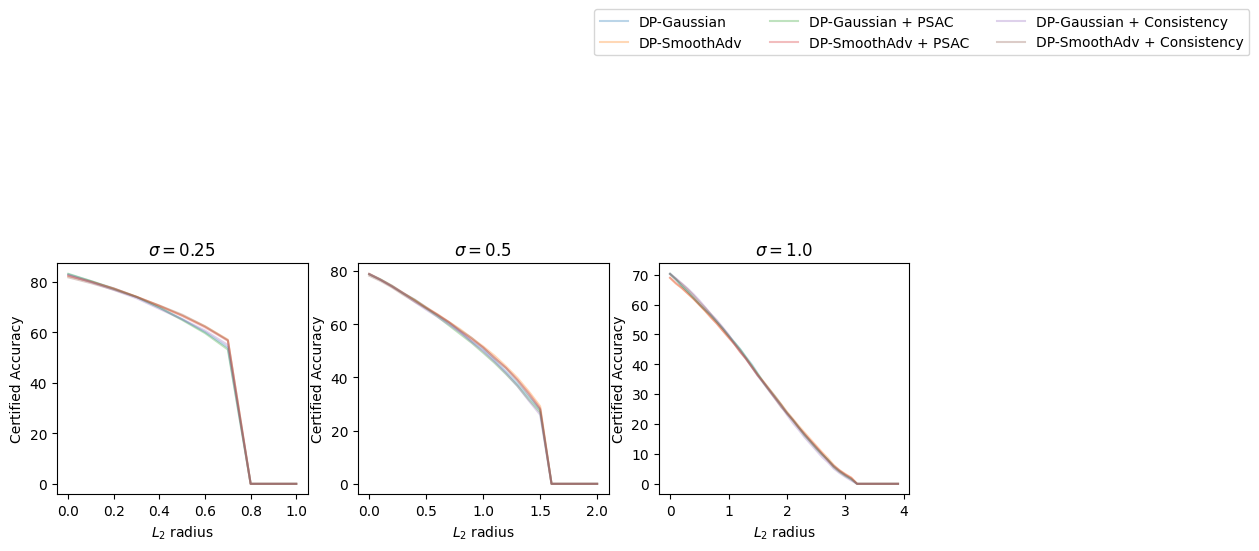

<Figure size 640x480 with 0 Axes>

In [23]:
checkpoint_paths = [[
    '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23Apr16*',
    '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-adv-smooth*num_augmentations_2*Apr1[78]*',
    '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment-auto-clip_cnn*',
    '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-auto-clip-adv-smooth*psac_True_num_augmentations_2*Apr1[78]*',
    '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment*Apr20*',
    '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-adv-smooth*_num_augmentations_2*Apr20*',
],[
    '/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15Apr16*',
    '/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-adv-smooth*num_augmentations_2*Apr1[78]*',
    '/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment-auto-clip_cnn*',
    '/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-auto-clip-adv-smooth*psac_True_num_augmentations_2*Apr1[78]*',
    '/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment*Apr20*',
    '/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-adv-smooth*_num_augmentations_2*Apr20*'
]]

noise_std_to_end_radius = {0.25: 1.2, 0.5: 2.1, 1.0: 4.1}
keys_by_noise_std = defaultdict(list)
method_list = ["DP-Gaussian", "DP-SmoothAdv", "DP-Gaussian + PSAC", "DP-SmoothAdv + PSAC", "DP-Gaussian + Consistency", "DP-SmoothAdv + Consistency"]
sigma_results_list = []
for checkpoint_path in checkpoint_paths[1]:
    dir_list = glob.glob(checkpoint_path)
    test_result_df_dict = {}
    metric_dict = defaultdict(dict)
    key_list = []
    noise_std_list = []
    for j, dir in enumerate(dir_list):
        # print(dir)
        with open(os.path.join(dir, "config.json"), "r") as f:
            cfg = json.load(f)
        
        method = cfg['method']
        if cfg['method'] in ["dpsgd-auto-clip-adv-smooth", "dpsgd-augment-auto-clip"]:
            if not cfg['psac']:
                continue
            method += f"_psac_{cfg['psac']}"

        augment_noise_std = cfg["augment_noise_std"]
        num_augmentations = cfg['num_augmentations']
        if num_augmentations != 2:
            continue

        cur_key = dir
        keys_by_noise_std[augment_noise_std].append(dir)
        
        key_list.append(cur_key)
        noise_std_list.append(augment_noise_std)

        test_result_df = pd.read_json(os.path.join(dir, "test_results.json"))
        test_result_df_dict[cur_key] = test_result_df

    sigma_results = read_certified_robustness_results(key_list, test_result_df_dict, end_radius=4.1)
    sigma_results_list.append(sigma_results)
    # print(sigma_results)

fig, ax = plt.subplots(1, 3)
for i, (noise_std, end_radius) in enumerate(zip([0.25, 0.5, 1.0], [1.2, 2.1, 4.1])):
    dirs = keys_by_noise_std[noise_std]
    end_radius = noise_std_to_end_radius[noise_std]
    end_index = int(end_radius / 0.1)
    # print(dirs)
    # print(method_list)
    # print(len(dirs))
    # print(len(method_list))
    for dir, method, sigma_results in zip(dirs, method_list, sigma_results_list):
        avg = pd.DataFrame.from_dict(sigma_results[noise_std][dir]).iloc[0].head(end_index)
        ax[i].plot(avg, alpha=0.3, label=method)
    ax[i].set_xlabel("$L_2$ radius")
    ax[i].set_title(f"$\sigma={noise_std}$")
    ax[i].set_ylabel("Certified Accuracy")


    plt.legend(loc='center', bbox_to_anchor=(1.05, 2), ncol=3)
    fig.set_size_inches(11, 3)

    plt.tight_layout()

plt.show()
plt.clf()

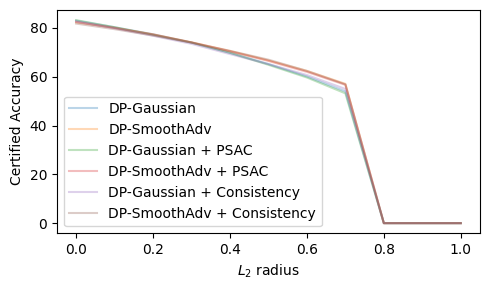

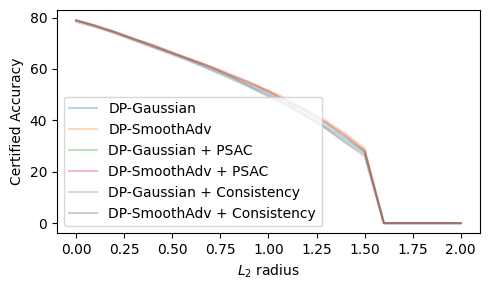

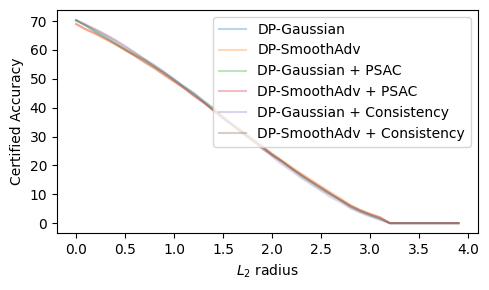

<Figure size 640x480 with 0 Axes>

In [26]:
checkpoint_paths = [[
    '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23Apr16*',
    '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-adv-smooth*num_augmentations_2*Apr1[78]*',
    '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment-auto-clip_cnn*',
    '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-auto-clip-adv-smooth*psac_True_num_augmentations_2*Apr1[78]*',
    '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment*Apr20*',
    '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-adv-smooth*_num_augmentations_2*Apr20*',
],[
    '/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15Apr16*',
    '/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-adv-smooth*num_augmentations_2*Apr1[78]*',
    '/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment-auto-clip_cnn*',
    '/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-auto-clip-adv-smooth*psac_True_num_augmentations_2*Apr1[78]*',
    '/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment*Apr20*',
    '/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-adv-smooth*_num_augmentations_2*Apr20*'
]]

noise_std_to_end_radius = {0.25: 1.2, 0.5: 2.1, 1.0: 4.1}
keys_by_noise_std = defaultdict(list)
method_list = ["DP-Gaussian", "DP-SmoothAdv", "DP-Gaussian + PSAC", "DP-SmoothAdv + PSAC", "DP-Gaussian + Consistency", "DP-SmoothAdv + Consistency"]
sigma_results_list = []
for checkpoint_path in checkpoint_paths[1]:
    dir_list = glob.glob(checkpoint_path)
    test_result_df_dict = {}
    metric_dict = defaultdict(dict)
    key_list = []
    noise_std_list = []
    for j, dir in enumerate(dir_list):
        # print(dir)
        with open(os.path.join(dir, "config.json"), "r") as f:
            cfg = json.load(f)
        
        method = cfg['method']
        if cfg['method'] in ["dpsgd-auto-clip-adv-smooth", "dpsgd-augment-auto-clip"]:
            if not cfg['psac']:
                continue
            method += f"_psac_{cfg['psac']}"

        augment_noise_std = cfg["augment_noise_std"]
        num_augmentations = cfg['num_augmentations']
        if num_augmentations != 2:
            continue

        cur_key = dir
        keys_by_noise_std[augment_noise_std].append(dir)
        
        key_list.append(cur_key)
        noise_std_list.append(augment_noise_std)

        test_result_df = pd.read_json(os.path.join(dir, "test_results.json"))
        test_result_df_dict[cur_key] = test_result_df

    sigma_results = read_certified_robustness_results(key_list, test_result_df_dict, end_radius=4.1)
    sigma_results_list.append(sigma_results)
    # print(sigma_results)

# fig, ax = plt.subplots(1, 3)
for i, (noise_std, end_radius) in enumerate(zip([0.25, 0.5, 1.0], [1.2, 2.1, 4.1])):
    dirs = keys_by_noise_std[noise_std]
    end_radius = noise_std_to_end_radius[noise_std]
    end_index = int(end_radius / 0.1)
    # print(dirs)
    # print(method_list)
    # print(len(dirs))
    # print(len(method_list))
    plt.figure(figsize=(5, 3))
    for dir, method, sigma_results in zip(dirs, method_list, sigma_results_list):
        avg = pd.DataFrame.from_dict(sigma_results[noise_std][dir]).iloc[0].head(end_index)
        plt.plot(avg, alpha=0.3, label=method)
    plt.xlabel("$L_2$ radius")
    # ax[i].set_title(f"$\sigma={noise_std}$")
    plt.ylabel("Certified Accuracy")


    # plt.legend(loc='center', bbox_to_anchor=(1.05, 2), ncol=3)
    plt.legend()
    fig.set_size_inches(11, 3)

    plt.tight_layout()

plt.show()
plt.clf()

noise_std 0.25


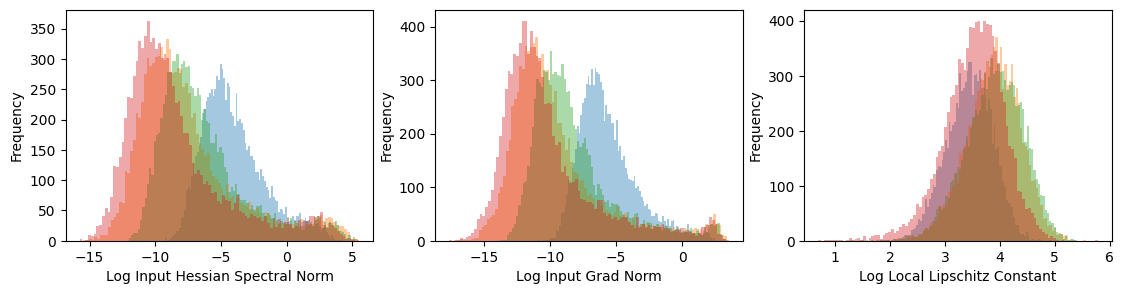

noise_std 0.5


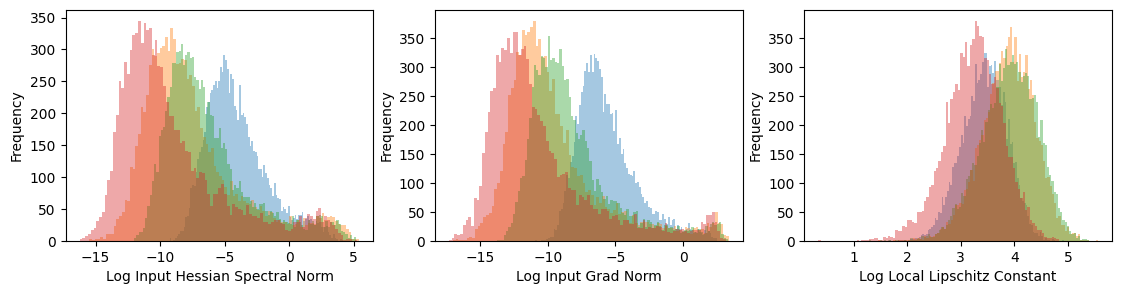

noise_std 1.0


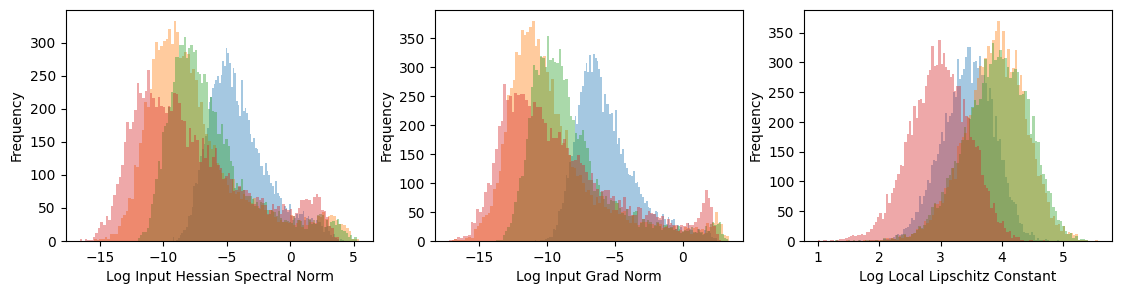

noise_std 0.25


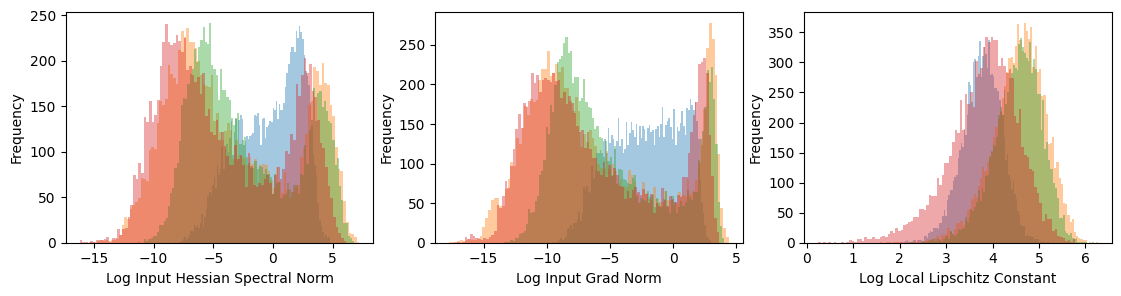

noise_std 0.5


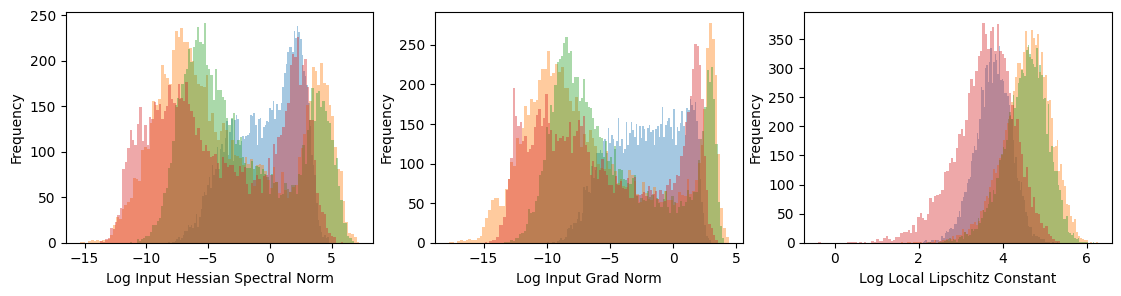

noise_std 1.0


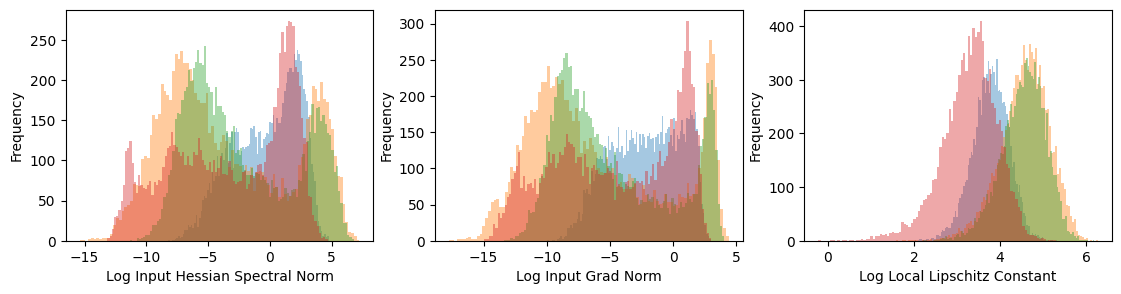

In [3]:
base_dir_list = [
    [
        "/data2/paulwu/robust-dp-label-noise/runs/mnist_regular_cnn_sgd_lr_0.01_bsz_512_clip_bound_0.1_sigma_0.8Mar23_17-57-37",
        "/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23Mar23_17-57-54",
        "/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-auto-clip_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23_psac_TrueMay02_22-45-57",
    ],[
        "/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_regular_cnn_sgd_lr_0.01_bsz_512_clip_bound_0.1_sigma_0.8Mar30_22-20-58",
        "/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15Mar30_22-21-12",
        "/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-auto-clip_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15_psac_TrueMay03_00-42-09",
    ]
]
checkpoint_paths_list = [
    [
        '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23Apr16*',
    ],[
        "/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15Apr16*",
    ]
]
key_to_color_dict = dict(zip(["Regular", "DPSGD", "PSAC", "DP-Gaussian", "DP-SmoothAdv", "DP-Stability", "DP-MACER"], ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']))
key_list = ["Regular", "DPSGD", "PSAC", "DP-Gaussian"]
# matric_to_key_dict = {"hess_eigen_val": "Max Abs Hessian Eigenvalue", "local_lip": "Local Lipschitz Constant", "input_grad_norm": "Input Grad Norm"}
# matric_to_key_dict = {"hess_eigen_val": "Max Abs Hessian Eigenvalue", "local_lip": "Local Lipschitz Constant", "input_grad_norm": "Input Grad Norm", "normlized_input_grad_norm": "Normalized Input Grad Norm"}
matric_to_key_dict = {"hess_eigen_val": "Input Hessian Spectral Norm", "local_lip": "Local Lipschitz Constant", "input_grad_norm": "Input Grad Norm", "normlized_input_grad_norm": "Normalized Input Grad Norm"}

for id, checkpoint_paths in enumerate(checkpoint_paths_list):
    for checkpoint_path in checkpoint_paths:
        noise_std_dict = defaultdict(list)
        dir_list = glob.glob(checkpoint_path)
        # print(dir_list)
        for dir in dir_list:
            with open(os.path.join(dir, "config.json"), "r") as f:
                cfg = json.load(f)
            
            augment_noise_std = cfg["augment_noise_std"]
            num_augmentations = cfg['num_augmentations']
            if num_augmentations == 2:
                noise_std_dict[augment_noise_std].append(dir)
    
    for i, noise_std in enumerate([0.25, 0.5, 1.0]):
        print("noise_std", noise_std)
        fig, ax = plt.subplots(1, 3)
        # dir_list = baseline_paths + noise_std_dict[noise_std]
        dir_list = noise_std_dict[noise_std]
        dir_list = base_dir_list[id] + dir_list
        for j, dir in enumerate(dir_list):
            test_result_df = pd.read_json(os.path.join(dir, "test_results.json"))
            for i, metric in enumerate(["hess_eigen_val", "input_grad_norm", "local_lip"]):
                ax[i].hist(np.log(test_result_df[metric]), bins=100, alpha=0.4, label=key_list[j], color = key_to_color_dict[key_list[j]])
                ax[i].set_xlabel(f"Log {matric_to_key_dict[metric]}")
                ax[i].set_ylabel("Frequency")
            # ax[k].set_title(f"{matric_to_key_dict[metric]}")
        fig.set_size_inches(13.5, 3)
        # plt.legend(bbox_to_anchor=(1.05, 1.4), ncol=4)
        plt.show()
        plt.close()

noise_std 0.25


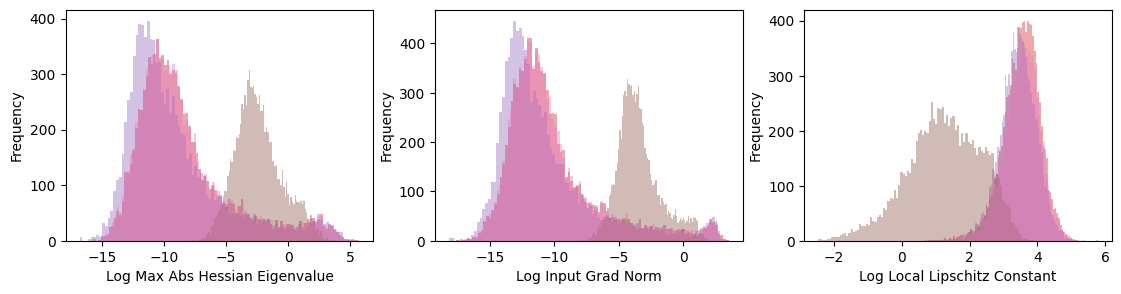

noise_std 0.5


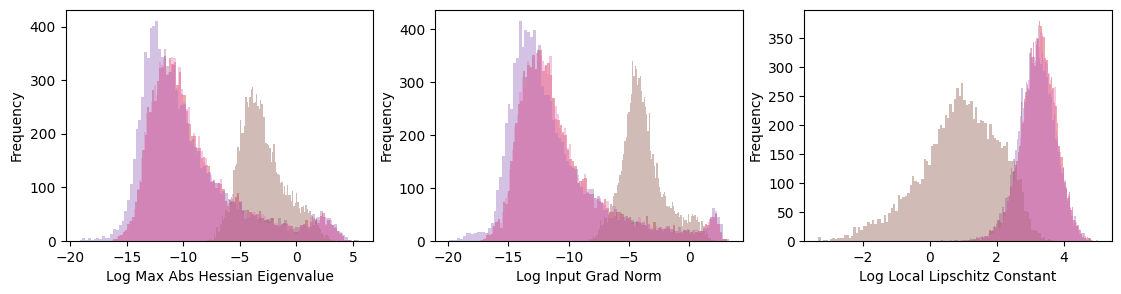

noise_std 1.0


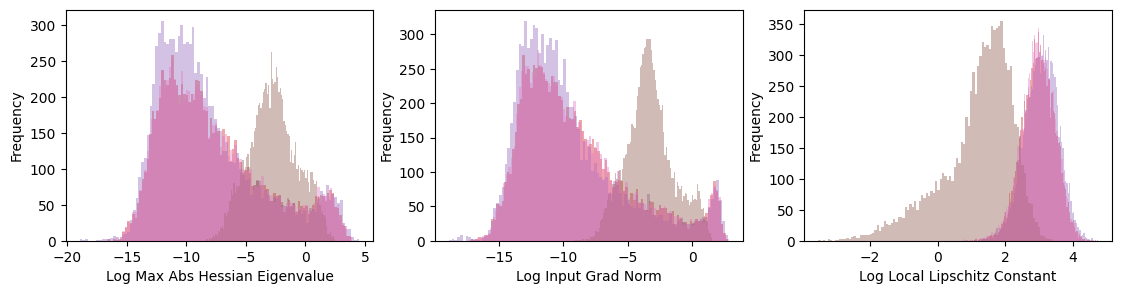

noise_std 0.25


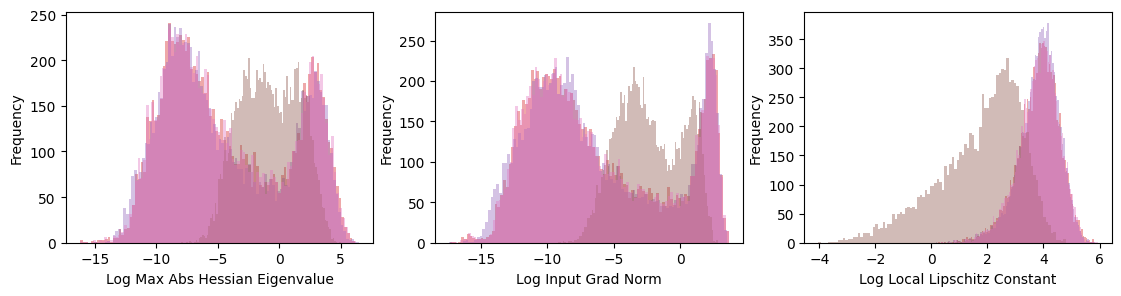

noise_std 0.5


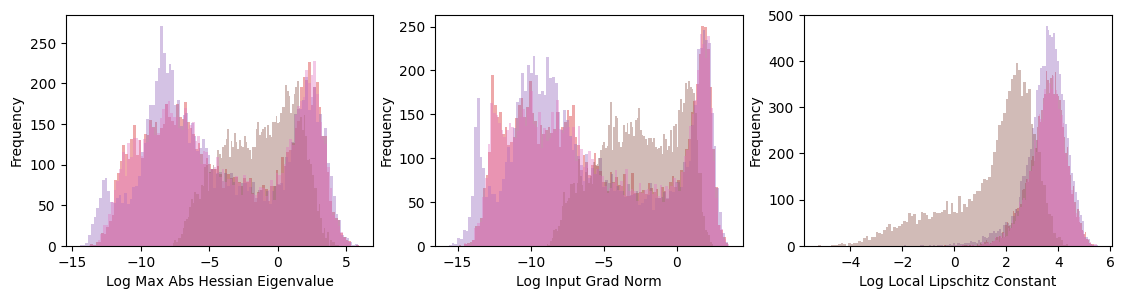

noise_std 1.0


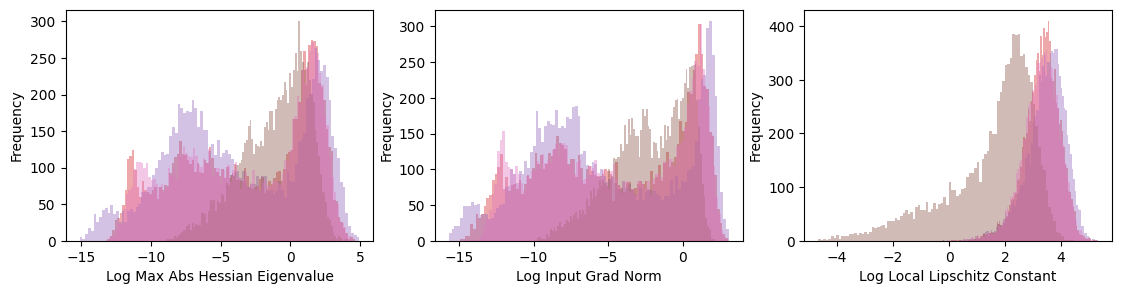

In [6]:
base_dir_list = [
    [
        "/data2/paulwu/robust-dp-label-noise/runs/mnist_regular_cnn_sgd_lr_0.01_bsz_512_clip_bound_0.1_sigma_0.8Mar23_17-57-37",
        "/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23Mar23_17-57-54",
        "/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-auto-clip_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23_psac_TrueMay02_22-45-57",
    ],[
        "/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_regular_cnn_sgd_lr_0.01_bsz_512_clip_bound_0.1_sigma_0.8Mar30_22-20-58",
        "/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15Mar30_22-21-12",
        "/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-auto-clip_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15_psac_TrueMay03_00-42-09",
    ]
]

checkpoint_paths_list = [
    [
        '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23Apr16*',
        '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-adv-smooth*num_augmentations_2*Apr1[78]*',
        '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment*Apr22*',
        '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment*Apr21_1[67]*',
    ],[
        '/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15Apr16*',
        '/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-adv-smooth*num_augmentations_2*Apr1[78]*',
        '/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment*Apr22*',
        '/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment*Apr21_1[67]*',
    ]   
]
key_list = ["DP-Gaussian", "DP-SmoothAdv", "DP-Stability", "DP-MACER"]

for id, checkpoint_paths in enumerate(checkpoint_paths_list):
    noise_std_dict = defaultdict(list)
    for checkpoint_path in checkpoint_paths:
        dir_list = glob.glob(checkpoint_path)
        # print(dir_list)
        for dir in dir_list:
            with open(os.path.join(dir, "config.json"), "r") as f:
                cfg = json.load(f)
            
            augment_noise_std = cfg["augment_noise_std"]
            num_augmentations = cfg['num_augmentations']
            if num_augmentations == 2:
                noise_std_dict[augment_noise_std].append(dir)

    for i, noise_std in enumerate([0.25, 0.5, 1.0]):
        print("noise_std", noise_std)
        fig, ax = plt.subplots(1, 3)
        
        dir_list = noise_std_dict[noise_std]
        for j, dir in enumerate(dir_list):
            test_result_df = pd.read_json(os.path.join(dir, "test_results.json"))
            for i, metric in enumerate(["hess_eigen_val", "input_grad_norm", "local_lip"]):
            # for k, metric in enumerate(["hess_eigen_val", "normlized_input_grad_norm", "local_lip"]):
                ax[i].hist(np.log(test_result_df[metric]), bins=100, alpha=0.4, label=key_list[j], color = key_to_color_dict[key_list[j]])
                ax[i].set_xlabel(f"Log {matric_to_key_dict[metric]}")
                ax[i].set_ylabel("Frequency")
            # ax[k].set_title(f"{matric_to_key_dict[metric]}")
        fig.set_size_inches(13.5, 3)
        # plt.legend(bbox_to_anchor=(1.05, 1.4), ncol=4)
        plt.show()
        plt.close()

noise_std 0.25


/mnt/tmp/ipykernel_32414/3797267633.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct_examples[cur_key] = correct_examples[cur_key].apply(lambda x: round(x, 1))
/mnt/tmp/ipykernel_32414/3797267633.py:49: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_scores = correct_examples.groupby(cur_key).mean().reset_index()
/mnt/tmp/ipykernel_32414/3797267633.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

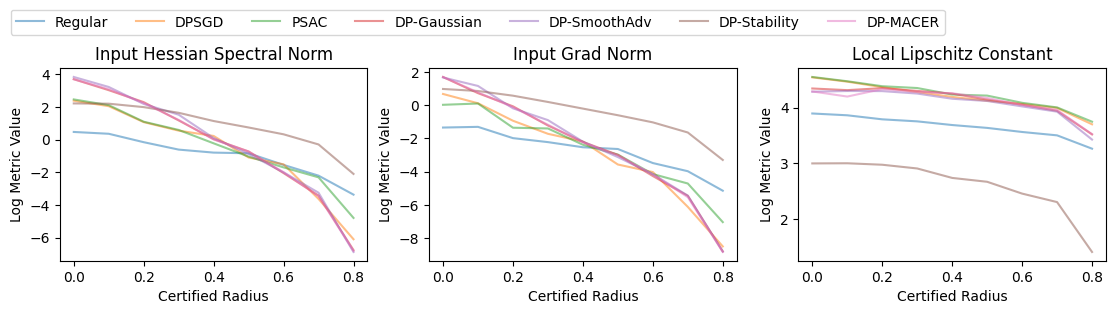

noise_std 0.25


/mnt/tmp/ipykernel_32414/3797267633.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct_examples[cur_key] = correct_examples[cur_key].apply(lambda x: round(x, 1))
/mnt/tmp/ipykernel_32414/3797267633.py:49: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_scores = correct_examples.groupby(cur_key).mean().reset_index()
/mnt/tmp/ipykernel_32414/3797267633.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

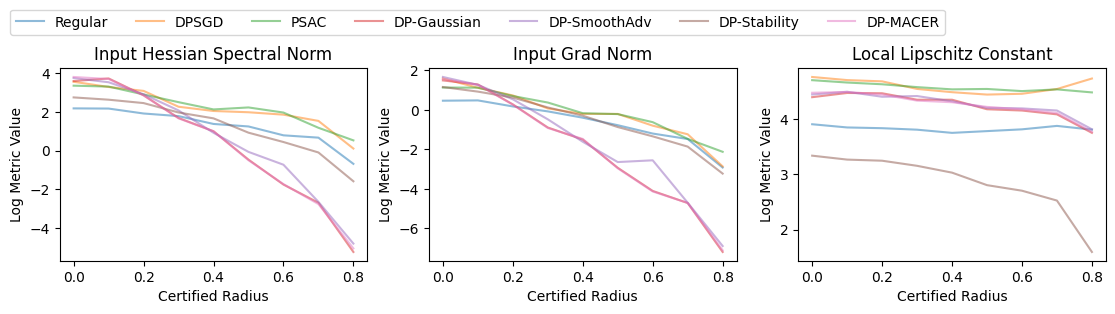

In [4]:

checkpoint_paths_list = [
    [
        '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23Apr16*',
        '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-adv-smooth*num_augmentations_2*Apr1[78]*',
        '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment*Apr22*',
        '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment*Apr21_1[67]*',
    ],[
        '/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15Apr16*',
        '/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-adv-smooth*num_augmentations_2*Apr1[78]*',
        '/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment*Apr22*',
        '/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment*Apr21_1[67]*',
    ]   
]


key_to_color_dict = dict(zip(["Regular", "DPSGD", "PSAC", "DP-Gaussian", "DP-SmoothAdv", "DP-Stability", "DP-MACER"], ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']))
key_list = ["Regular", "DPSGD", "PSAC", "DP-Gaussian", "DP-SmoothAdv", "DP-Stability", "DP-MACER"]
matric_to_key_dict = {"hess_eigen_val": "Input Hessian Spectral Norm", "local_lip": "Local Lipschitz Constant", "input_grad_norm": "Input Grad Norm", "normlized_input_grad_norm": "Normalized Input Grad Norm"}


for id, checkpoint_paths in enumerate(checkpoint_paths_list):
    noise_std_dict = defaultdict(list)
    for checkpoint_path in checkpoint_paths:
        dir_list = glob.glob(checkpoint_path)
        for dir in dir_list:
            with open(os.path.join(dir, "config.json"), "r") as f:
                cfg = json.load(f)
            
            augment_noise_std = cfg["augment_noise_std"]
            num_augmentations = cfg['num_augmentations']
            if num_augmentations == 2:
                noise_std_dict[augment_noise_std].append(dir)

    noise_std = 0.25
    
    print("noise_std", noise_std)
    fig, ax = plt.subplots(1, 3)
    dir_list = noise_std_dict[noise_std]
    dir_list = base_dir_list[id] + dir_list

    # bin the datapoints by the certfied radius, then for each bin, compute the average metric value
    for j, dir in enumerate(dir_list):
        cur_key = f'certified_radius_{noise_std}'
        test_result_df = pd.read_json(os.path.join(dir, "test_results.json"))
        # print(test_result_df)
        
        correct_examples = test_result_df[test_result_df[f'certified_correct_{noise_std}'] == True]
        correct_examples[cur_key] = correct_examples[cur_key].apply(lambda x: round(x, 1))
        grouped_scores = correct_examples.groupby(cur_key).mean().reset_index()
        for i, metric in enumerate(["hess_eigen_val", "input_grad_norm", "local_lip"]):
            ax[i].plot(grouped_scores[cur_key], np.log(grouped_scores[metric]), alpha=0.5, label=key_list[j], color = key_to_color_dict[key_list[j]])
            ax[i].set_xlabel("Certified Radius")
            ax[i].set_ylabel("Log Metric Value")
            ax[i].set_title(f"{matric_to_key_dict[metric]}")
        ax[i].legend()
    fig.set_size_inches(13.5, 2.5)
    plt.legend(bbox_to_anchor=(0.5, 1.34), ncol=7)
    plt.show()
    plt.close()


noise_std 0.5
cut_off 0.5
cut_off 1.0
cut_off 1.5


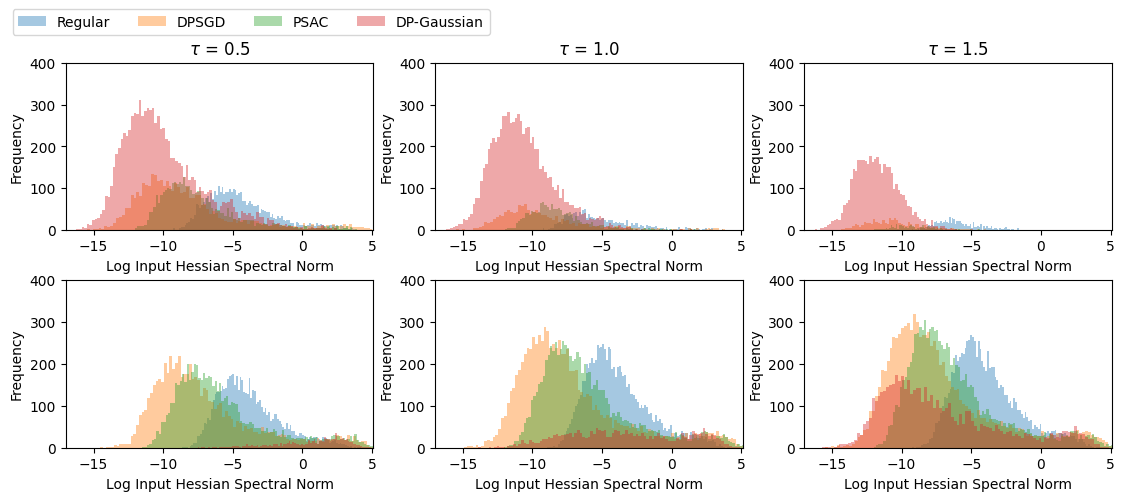

cut_off 0.5
cut_off 1.0
cut_off 1.5


<Figure size 640x480 with 0 Axes>

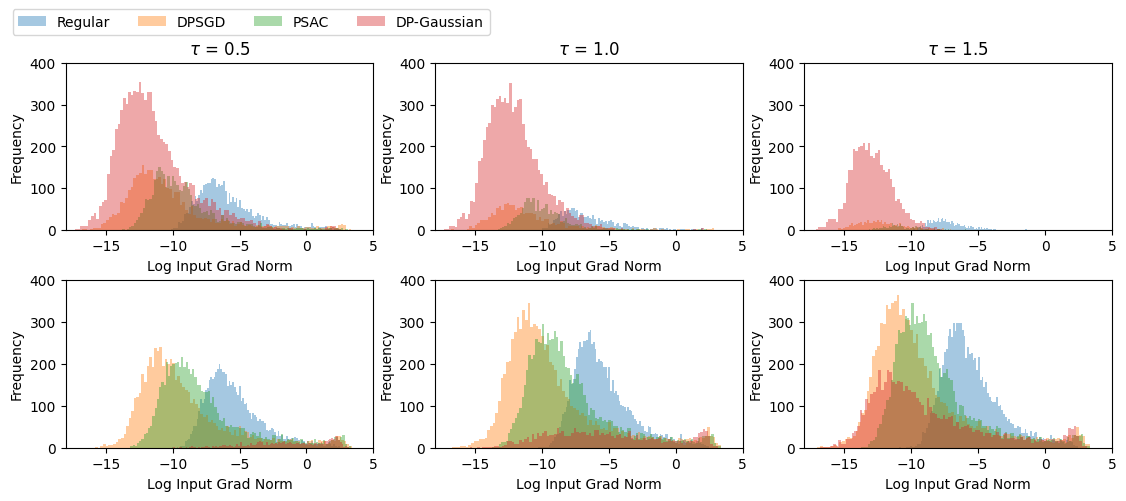

cut_off 0.5
cut_off 1.0
cut_off 1.5


<Figure size 640x480 with 0 Axes>

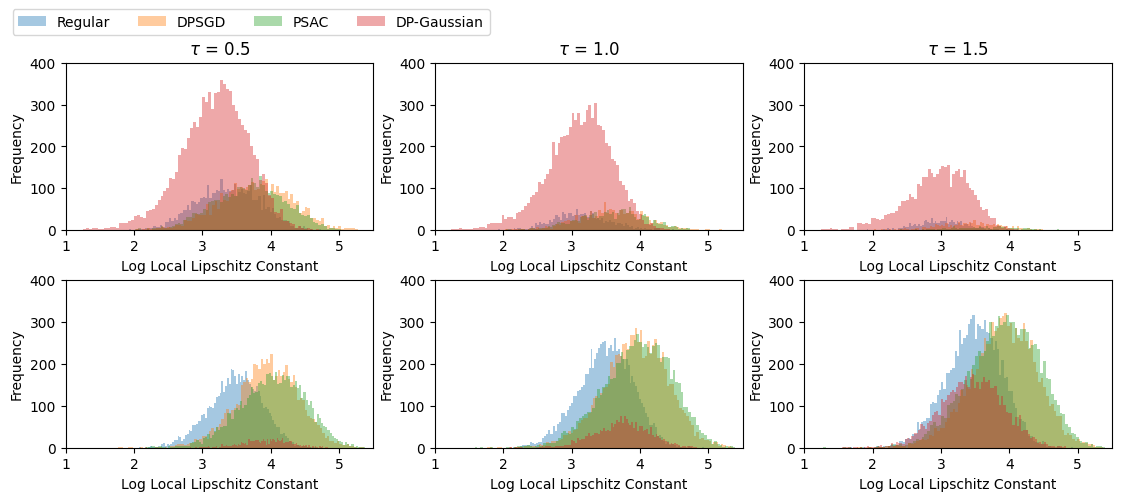

<Figure size 640x480 with 0 Axes>

In [6]:
base_dir_list = [
    [
        "/data2/paulwu/robust-dp-label-noise/runs/mnist_regular_cnn_sgd_lr_0.01_bsz_512_clip_bound_0.1_sigma_0.8Mar23_17-57-37",
        "/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23Mar23_17-57-54",
        "/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-auto-clip_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23_psac_TrueMay02_22-45-57",
    ],[
        "/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_regular_cnn_sgd_lr_0.01_bsz_512_clip_bound_0.1_sigma_0.8Mar30_22-20-58",
        "/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15Mar30_22-21-12",
        "/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-auto-clip_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15_psac_TrueMay03_00-42-09",
    ]
]
checkpoint_paths_list = [
    [
        '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23Apr16*',
    ],[
        "/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15Apr16*",
    ]
]
key_to_color_dict = dict(zip(["Regular", "DPSGD", "PSAC", "DP-Gaussian", "DP-SmoothAdv", "DP-Stability", "DP-MACER"], ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']))
key_list = ["Regular", "DPSGD", "PSAC", "DP-Gaussian"]
# matric_to_key_dict = {"hess_eigen_val": "Max Abs Hessian Eigenvalue", "local_lip": "Local Lipschitz Constant", "input_grad_norm": "Input Grad Norm"}
matric_to_key_dict = {"hess_eigen_val": "Input Hessian Spectral Norm", "local_lip": "Local Lipschitz Constant", "input_grad_norm": "Input Grad Norm", "normlized_input_grad_norm": "Normalized Input Grad Norm"}
metric_to_limit_dict = {"hess_eigen_val": (-17, 5.1), "local_lip": (1, 5.5), "input_grad_norm": (-18, 5)}


checkpoint_paths = checkpoint_paths_list[0]
id = 0
noise_std_dict = defaultdict(list)
for checkpoint_path in checkpoint_paths:
    dir_list = glob.glob(checkpoint_path)
    # print(dir_list)
    for dir in dir_list:
        with open(os.path.join(dir, "config.json"), "r") as f:
            cfg = json.load(f)
        
        augment_noise_std = cfg["augment_noise_std"]
        num_augmentations = cfg['num_augmentations']
        if num_augmentations == 2:
            noise_std_dict[augment_noise_std].append(dir)

noise_std = 0.5
print("noise_std", noise_std)

dir_list = noise_std_dict[noise_std]
dir_list = base_dir_list[id] + dir_list

for k, metric in enumerate(["hess_eigen_val", "input_grad_norm", "local_lip"]):
    fig, ax = plt.subplots(2, 3)
    for i, cut_off in enumerate(np.arange(0.5, 1.51, 0.5)):
    # for cut_off in [0.5, 1.5]:
        print("cut_off", cut_off)
        
        for j, dir in enumerate(dir_list):
            cur_key = f'certified_radius_{noise_std}'
            test_result_df = pd.read_json(os.path.join(dir, "test_results.json"))
            correct_examples = test_result_df[test_result_df[f'certified_correct_{noise_std}'] == True]
            max_radius = correct_examples[cur_key].max()
            pos_df = test_result_df[test_result_df[cur_key] > cut_off]
            neg_df = test_result_df[test_result_df[cur_key] <= cut_off]
            for true_false_id, df in enumerate([pos_df, neg_df]):
                # print("True" if true_false_id == 0 else "False")
                # for k, metric in enumerate(["hess_eigen_val", "input_grad_norm", "local_lip"]):
                # metric = "local_lip"
                ax[true_false_id, i].hist(np.log(df[metric]), bins=100, alpha=0.4, label=key_list[j], color = key_to_color_dict[key_list[j]])
                
                plt.subplots_adjust(hspace=0.3)
                plt.subplots_adjust(wspace=0.2)
                ax[true_false_id, i].set_xlim(metric_to_limit_dict[metric])
                ax[true_false_id, i].set_ylim(0, 400)
                # ax[k].plot(grouped_scores[cur_key], np.log(grouped_scores[metric]), alpha=0.5, label=key_list[j], color = key_to_color_dict[key_list[j]])
                # ax[true_false_id, k].set_xlabel("Certified Radius")
                if true_false_id == 0:
                    ax[true_false_id, i].set_title(rf"$\tau$ = {cut_off}")
                # if i == 0:
                ax[true_false_id, i].set_ylabel("Frequency")
                # if i == 2 and true_false_id == 1:
                ax[true_false_id, i].set_xlabel(f"Log {matric_to_key_dict[metric]}")
    plt.legend(bbox_to_anchor=(-1, 2.66), ncol=4)
    fig.set_size_inches(13.5, 5)
    plt.show()
    plt.clf()


noise_std 0.5
cut_off 0.5
cut_off 1.0
cut_off 1.5


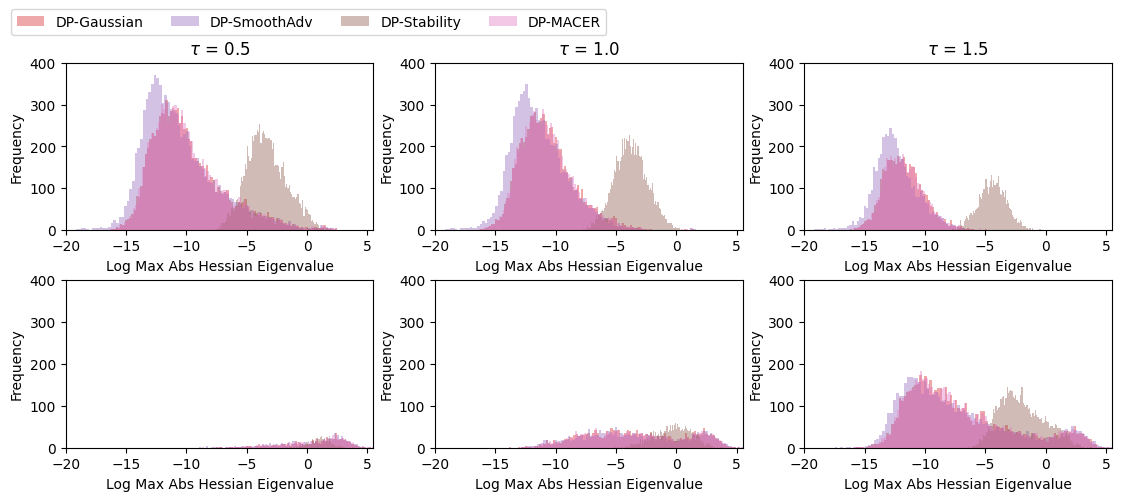

cut_off 0.5
cut_off 1.0
cut_off 1.5


<Figure size 640x480 with 0 Axes>

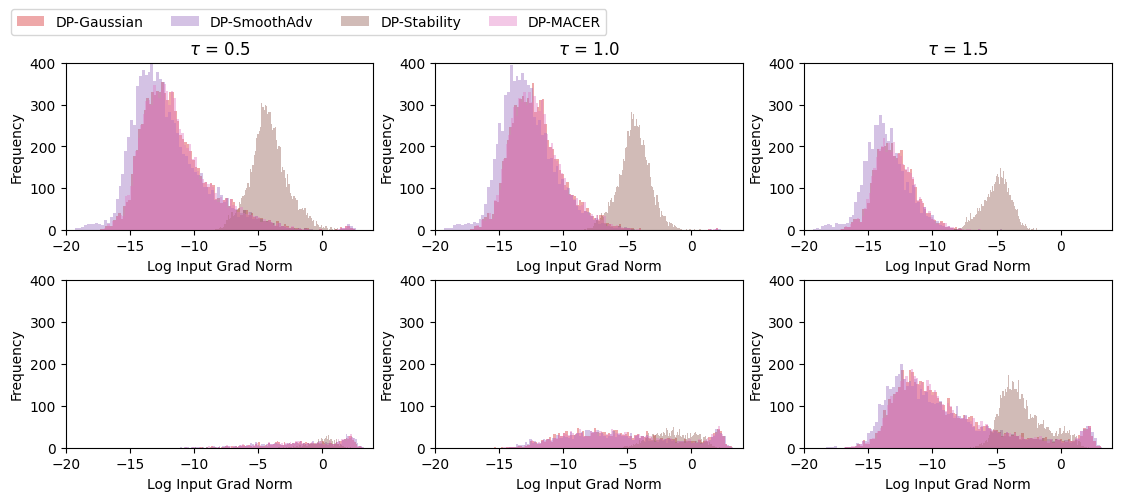

cut_off 0.5
cut_off 1.0
cut_off 1.5


<Figure size 640x480 with 0 Axes>

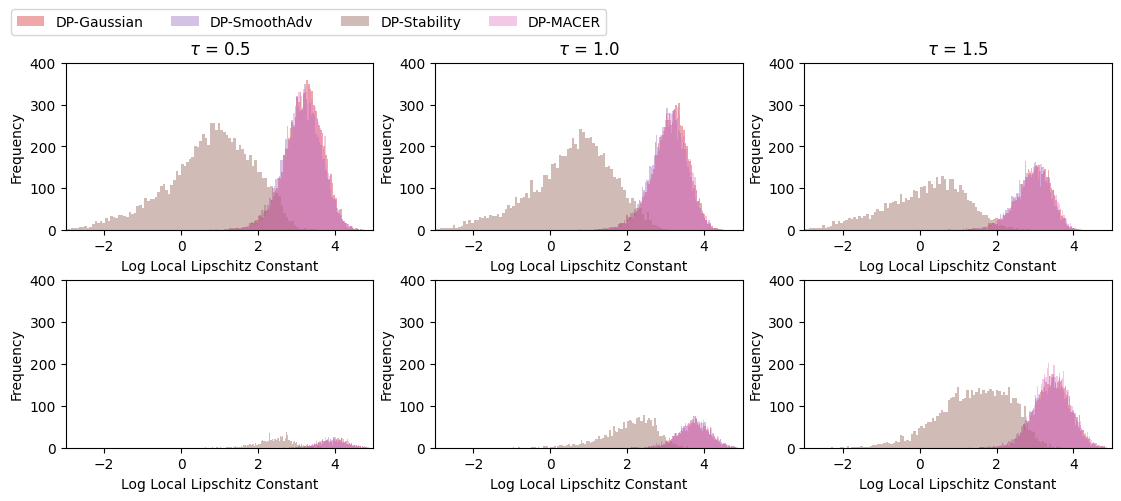

<Figure size 640x480 with 0 Axes>

In [7]:

checkpoint_paths_list = [
    [
        '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23Apr16*',
        '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-adv-smooth*num_augmentations_2*Apr1[78]*',
        '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment*Apr22*',
        '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment*Apr21_1[67]*',
    ],[
        '/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15Apr16*',
        '/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-adv-smooth*num_augmentations_2*Apr1[78]*',
        '/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment*Apr22*',
        '/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment*Apr21_1[67]*',
    ]   
]

key_list = ["DP-Gaussian", "DP-SmoothAdv", "DP-Stability", "DP-MACER"]


key_to_color_dict = dict(zip(["Regular", "DPSGD", "PSAC", "DP-Gaussian", "DP-SmoothAdv", "DP-Stability", "DP-MACER"], ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']))
key_list = ["DP-Gaussian", "DP-SmoothAdv", "DP-Stability", "DP-MACER"]
matric_to_key_dict = {"hess_eigen_val": "Max Abs Hessian Eigenvalue", "local_lip": "Local Lipschitz Constant", "input_grad_norm": "Input Grad Norm", "normlized_input_grad_norm": "Normalized Input Grad Norm"}
metric_to_limit_dict = {"hess_eigen_val": (-20, 5.5), "local_lip": (-3, 5), "input_grad_norm": (-20, 4)}

# use pandas cut function to bin the scores column

# for id, checkpoint_paths in enumerate(checkpoint_paths_list):
checkpoint_paths = checkpoint_paths_list[0]
id = 0
noise_std_dict = defaultdict(list)
for checkpoint_path in checkpoint_paths:
    dir_list = glob.glob(checkpoint_path)
    # print(dir_list)
    for dir in dir_list:
        with open(os.path.join(dir, "config.json"), "r") as f:
            cfg = json.load(f)
        
        augment_noise_std = cfg["augment_noise_std"]
        num_augmentations = cfg['num_augmentations']
        if num_augmentations == 2:
            noise_std_dict[augment_noise_std].append(dir)


# for i, noise_std in enumerate([0.25, 0.5, 1.0]):
noise_std = 0.5
print("noise_std", noise_std)

dir_list = noise_std_dict[noise_std]


# bin the datapoints by the certfied radius, then for each bin, compute the average metric value

for k, metric in enumerate(["hess_eigen_val", "input_grad_norm", "local_lip"]):
    fig, ax = plt.subplots(2, 3)
    for i, cut_off in enumerate(np.arange(0.5, 1.51, 0.5)):
    # for cut_off in [0.5, 1.5]:
        print("cut_off", cut_off)
        
        for j, dir in enumerate(dir_list):
            cur_key = f'certified_radius_{noise_std}'
            test_result_df = pd.read_json(os.path.join(dir, "test_results.json"))
            correct_examples = test_result_df[test_result_df[f'certified_correct_{noise_std}'] == True]
            max_radius = correct_examples[cur_key].max()
            pos_df = test_result_df[test_result_df[cur_key] > cut_off]
            neg_df = test_result_df[test_result_df[cur_key] <= cut_off]
            for true_false_id, df in enumerate([pos_df, neg_df]):
                # print("True" if true_false_id == 0 else "False")
                # for k, metric in enumerate(["hess_eigen_val", "input_grad_norm", "local_lip"]):
                # metric = "local_lip"
                ax[true_false_id, i].hist(np.log(df[metric]), bins=100, alpha=0.4, label=key_list[j], color = key_to_color_dict[key_list[j]])
                
                plt.subplots_adjust(hspace=0.3)
                plt.subplots_adjust(wspace=0.2)
                ax[true_false_id, i].set_xlim(metric_to_limit_dict[metric])
                ax[true_false_id, i].set_ylim(0, 400)
                # ax[k].plot(grouped_scores[cur_key], np.log(grouped_scores[metric]), alpha=0.5, label=key_list[j], color = key_to_color_dict[key_list[j]])
                # ax[true_false_id, k].set_xlabel("Certified Radius")
                if true_false_id == 0:
                    ax[true_false_id, i].set_title(rf"$\tau$ = {cut_off}")
                # if i == 0:
                ax[true_false_id, i].set_ylabel("Frequency")
                # if i == 2 and true_false_id == 1:
                ax[true_false_id, i].set_xlabel(f"Log {matric_to_key_dict[metric]}")
    plt.legend(bbox_to_anchor=(-0.62, 2.66), ncol=4)
    fig.set_size_inches(13.5, 5)
    plt.show()
    plt.clf()


In [17]:
# augmentation = 8
baseline_paths = ["/data2/paulwu/robust-dp-label-noise/runs/mnist_regular_cnn_sgd_lr_0.01_bsz_512_clip_bound_0.1_sigma_0.8Mar23_17-57-37", 
                  "/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23Mar23_17-57-54"]

checkpoint_paths = [
    ['/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23Apr29_20-25-33', 
    '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-adv-smooth_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23_pgd_steps_2_no_grad_False_max_norm_64_num_augmentations_8_augment_noise_std_0.25Apr29_20-26-08', 
    '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23_trades_TrueApr29_20-26-00', 
    '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23_macer_TrueApr29_20-25-52'],
    ['/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23Apr29_20-59-58', 
    '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-adv-smooth_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23_pgd_steps_2_no_grad_False_max_norm_64_num_augmentations_8_augment_noise_std_0.5Apr29_20-55-54', 
    '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23_trades_TrueApr29_21-04-37', 
    '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23_macer_TrueApr29_21-04-51'],
    ['/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23Apr29_21-33-43', 
    '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-adv-smooth_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23_pgd_steps_2_no_grad_False_max_norm_64_num_augmentations_8_augment_noise_std_1.0Apr29_21-25-04', 
    '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23_trades_TrueApr29_21-42-05', 
    '/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23_macer_TrueApr29_21-43-29']
]

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


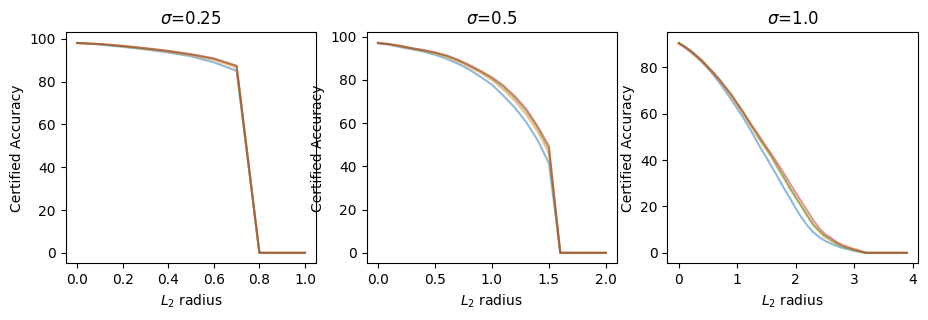

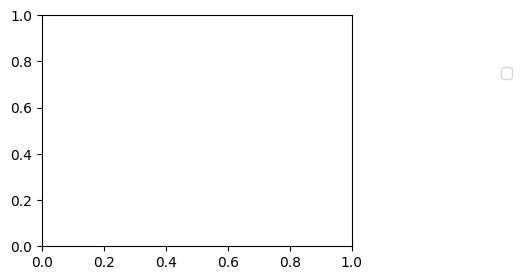

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


<Figure size 640x480 with 0 Axes>

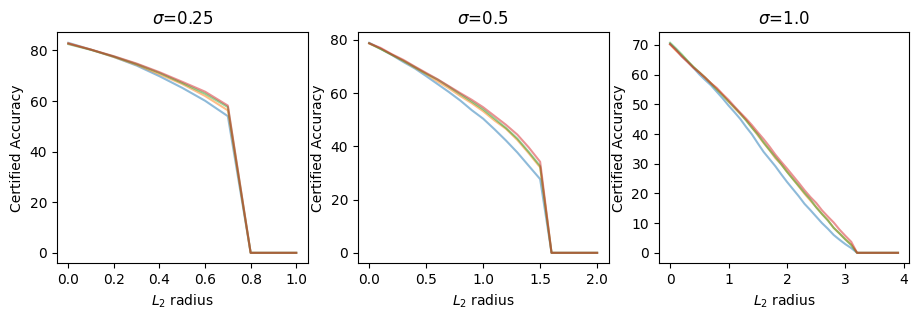

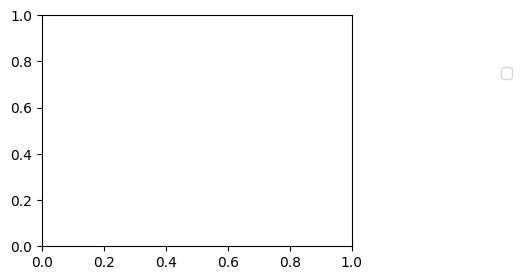

<Figure size 640x480 with 0 Axes>

In [10]:
# Hyperparameters study for DP-augment training
# dp-augment

zero_augmentation_paths = [
    [
        "/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23May14_23-51-43",
        "/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23May15_00-08-03",
        "/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23May15_00-25-48"
    ],
    [
        "/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15May14_23-51-58",
        "/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15May15_00-09-18",
        "/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15May15_00-25-25"
    ]
]

for checkpoint_path, zero_augmentation_path in zip(["/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23Apr16*",
                        "/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15Apr16*",
                        ], zero_augmentation_paths):
    dir_list = zero_augmentation_path + glob.glob(checkpoint_path)
    dir_list = glob.glob(checkpoint_path)
    test_result_df_dict = {}
    metric_dict = defaultdict(dict)
    key_list = []
    keys_by_noise_std_then_num_augmentations = defaultdict(dict)
    key_to_noise_std_dict = {}

    
    for j, dir in enumerate(dir_list):
        with open(os.path.join(dir, "config.json"), "r") as f:
            cfg = json.load(f)

        augment_noise_std = cfg["augment_noise_std"]
        num_augmentations = cfg['num_augmentations']
        
        cur_key = dir
        key_list.append(cur_key)

        test_result_df = pd.read_json(os.path.join(dir, "test_results.json"))
        test_result_df_dict[cur_key] = test_result_df
        num_correct_at_radius = len(test_result_df[test_result_df['correct'] == True])
        accuracy = num_correct_at_radius / len(test_result_df)

        metric_dict["dataset"][j] = cfg['dataset']
        metric_dict["method"][j] = cfg['method']
        metric_dict["accuracy"][j] = accuracy
        metric_dict["noise_std"][j] = augment_noise_std
        metric_dict["num_augmentation"][j] = num_augmentations
        keys_by_noise_std_then_num_augmentations[augment_noise_std][num_augmentations]=cur_key
        
        for sigma in [0.25, 0.5, 1.0]:

            if f'certified_radius_{sigma}' not in test_result_df:
                continue
            radius = test_result_df[f'certified_radius_{sigma}']
            correct = test_result_df[f'certified_correct_{sigma}']
            pred = test_result_df[f'certified_pred_{sigma}']
            certified_accuracy = len(test_result_df[correct == True]) / len(test_result_df)
            # print(sigma, certified_accuracy)
            # metric_dict[f"certified_accuracy_{sigma}"][j] = certified_accuracy
    # print(pd.DataFrame(metric_dict).sort_values(by="accuracy", ascending=False).to_string())

    # acc_df = pd.DataFrame(metric_dict).sort_values(by="accuracy", ascending=False)
    acc_df = pd.DataFrame(metric_dict)
    sigma_results = read_certified_robustness_results(key_list, test_result_df_dict, end_radius=4.1)
    fig, ax = plt.subplots(1, 3)
    for i, (noise_std, end_radius) in enumerate(zip([0.25, 0.5, 1.0], [1.2, 2.1, 4.1])):
        keys_by_num_augmentations = keys_by_noise_std_then_num_augmentations[noise_std]
        # fig = plt.figure(figsize=(8, 6), dpi=10)

        for num_augmentation, key in keys_by_num_augmentations.items():
            # print(noise_std, num_augmentation, key)
            avg = pd.DataFrame.from_dict(sigma_results[noise_std][key]).iloc[0].tolist()
            end_index = int(end_radius / 0.1)
            avg = avg[:end_index]
            x = np.arange(0.0, 8, 0.1)[:end_index]
            ax[i].plot(x, avg, alpha=0.5, label=f"Num Augmentations={num_augmentation}")
        ax[i].set_xlabel("$L_2$ radius")
        ax[i].set_title(f"$\sigma$={noise_std}")
        ax[i].set_ylabel("Certified Accuracy")
        plt.legend(loc='center', bbox_to_anchor=(1.5, 0.75))
        fig.set_size_inches(11, 3)
        # plt.tight_layout()

    plt.show()
    plt.clf()



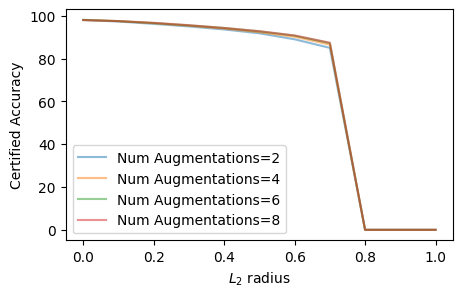

<Figure size 640x480 with 0 Axes>

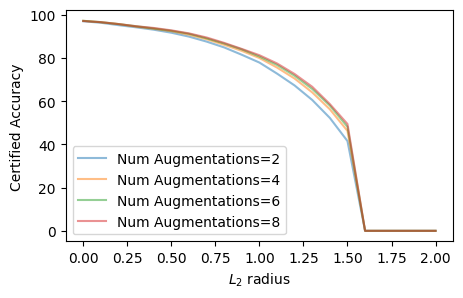

<Figure size 640x480 with 0 Axes>

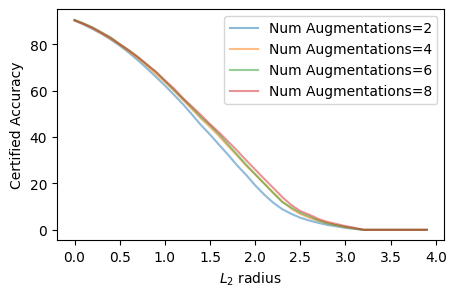

<Figure size 640x480 with 0 Axes>

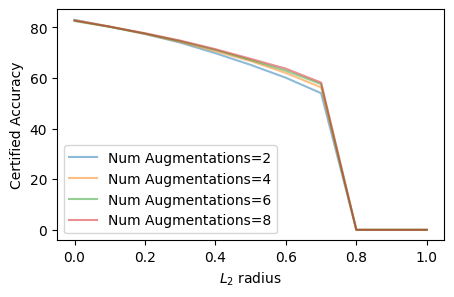

<Figure size 640x480 with 0 Axes>

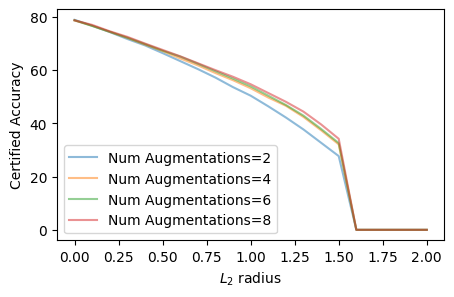

<Figure size 640x480 with 0 Axes>

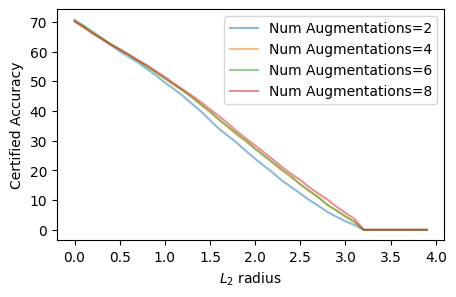

<Figure size 640x480 with 0 Axes>

In [22]:
# dp-augment

for checkpoint_path, zero_augmentation_path in zip(["/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23Apr16*",
                        "/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15Apr16*",
                        ], zero_augmentation_paths):
    # dir_list = zero_augmentation_path + glob.glob(checkpoint_path)
    dir_list = glob.glob(checkpoint_path)
    test_result_df_dict = {}
    metric_dict = defaultdict(dict)
    key_list = []
    keys_by_noise_std_then_num_augmentations = defaultdict(dict)
    key_to_noise_std_dict = {}

    
    for j, dir in enumerate(dir_list):
        with open(os.path.join(dir, "config.json"), "r") as f:
            cfg = json.load(f)

        augment_noise_std = cfg["augment_noise_std"]
        num_augmentations = cfg['num_augmentations']
        
        cur_key = dir
        key_list.append(cur_key)

        test_result_df = pd.read_json(os.path.join(dir, "test_results.json"))
        test_result_df_dict[cur_key] = test_result_df
        num_correct_at_radius = len(test_result_df[test_result_df['correct'] == True])
        accuracy = num_correct_at_radius / len(test_result_df)

        metric_dict["dataset"][j] = cfg['dataset']
        metric_dict["method"][j] = cfg['method']
        metric_dict["accuracy"][j] = accuracy
        metric_dict["noise_std"][j] = augment_noise_std
        metric_dict["num_augmentation"][j] = num_augmentations
        keys_by_noise_std_then_num_augmentations[augment_noise_std][num_augmentations]=cur_key
        
        for sigma in [0.25, 0.5, 1.0]:

            if f'certified_radius_{sigma}' not in test_result_df:
                continue
            radius = test_result_df[f'certified_radius_{sigma}']
            correct = test_result_df[f'certified_correct_{sigma}']
            pred = test_result_df[f'certified_pred_{sigma}']
            certified_accuracy = len(test_result_df[correct == True]) / len(test_result_df)
            # print(sigma, certified_accuracy)
            # metric_dict[f"certified_accuracy_{sigma}"][j] = certified_accuracy
    # print(pd.DataFrame(metric_dict).sort_values(by="accuracy", ascending=False).to_string())

    # acc_df = pd.DataFrame(metric_dict).sort_values(by="accuracy", ascending=False)
    acc_df = pd.DataFrame(metric_dict)
    sigma_results = read_certified_robustness_results(key_list, test_result_df_dict, end_radius=4.1)
    # fig, ax = plt.subplots(1, 3)
    
    for i, (noise_std, end_radius) in enumerate(zip([0.25, 0.5, 1.0], [1.2, 2.1, 4.1])):
        keys_by_num_augmentations = keys_by_noise_std_then_num_augmentations[noise_std]
        # fig = plt.figure(figsize=(8, 6), dpi=10)
        plt.figure(figsize=(5, 3))
        for num_augmentation, key in keys_by_num_augmentations.items():
            # print(noise_std, num_augmentation, key)
            avg = pd.DataFrame.from_dict(sigma_results[noise_std][key]).iloc[0].tolist()
            end_index = int(end_radius / 0.1)
            avg = avg[:end_index]
            x = np.arange(0.0, 8, 0.1)[:end_index]
            plt.plot(x, avg, alpha=0.5, label=f"Num Augmentations={num_augmentation}")
        plt.xlabel("$L_2$ radius")
        # plt.title(f"$\sigma$={noise_std}")
        plt.ylabel("Certified Accuracy")
        # plt.legend(loc='center', bbox_to_anchor=(1.3, 0.8))
        plt.legend()
        # fig.set_size_inches(11, 3)
        # plt.tight_layout()

        plt.show()
        plt.clf()



/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23May14_23-51-43
/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23May15_00-08-03
/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23May15_00-25-48
/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23May14_23-51-43
/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23May15_00-08-03


No handles with labels found to put in legend.


/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23May15_00-25-48


No handles with labels found to put in legend.


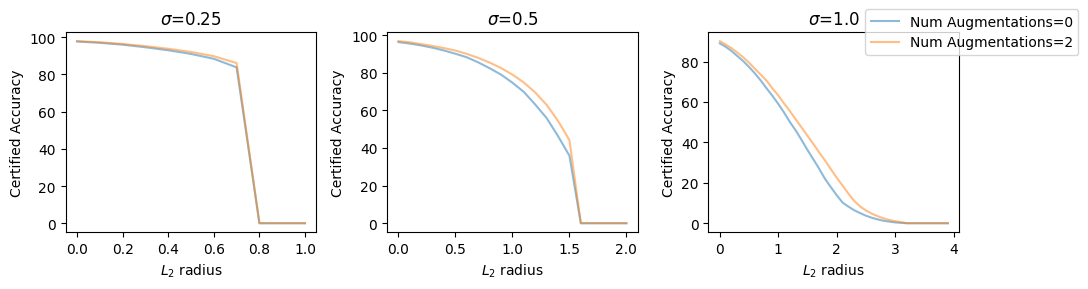

/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15May14_23-51-58
/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15May15_00-09-18
/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15May15_00-25-25
/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15May14_23-51-58
/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15May15_00-09-18


No handles with labels found to put in legend.


/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15May15_00-25-25


No handles with labels found to put in legend.


<Figure size 640x480 with 0 Axes>

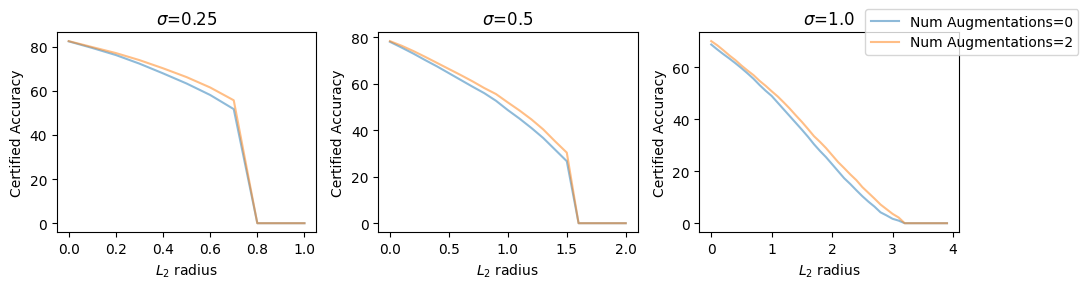

<Figure size 640x480 with 0 Axes>

In [17]:
# Hyperparameters study for DP-augment training
# dp-augment
zero_augmentation_paths = [
    [
        "/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23May14_23-51-43",
        "/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23May15_00-08-03",
        "/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23May15_00-25-48"
    ],
    [
        "/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15May14_23-51-58",
        "/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15May15_00-09-18",
        "/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15May15_00-25-25"
    ]
]
for checkpoint_path, zero_augmentation_path in zip(["/data2/paulwu/robust-dp-label-noise/runs/mnist_dpsgd-augment_cnn_sgd_lr_0.5_bsz_512_clip_bound_0.1_sigma_1.23May1[45]*",
                        "/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15May1[45]*",
                        # "/data2/paulwu/robust-dp-label-noise/runs/fashion-mnist_dpsgd-augment_cnn_sgd_lr_4_bsz_2048_clip_bound_0.1_sigma_2.15Apr16*",
                        ], zero_augmentation_paths):
    dir_list = glob.glob(checkpoint_path) + zero_augmentation_path
    test_result_df_dict = {}
    metric_dict = defaultdict(dict)
    key_list = []
    keys_by_noise_std_then_num_augmentations = defaultdict(dict)
    key_to_noise_std_dict = {}

    
    for j, dir in enumerate(dir_list):
        with open(os.path.join(dir, "config.json"), "r") as f:
            cfg = json.load(f)

        augment_noise_std = cfg["augment_noise_std"]
        num_augmentations = cfg['num_augmentations']
        
        cur_key = dir
        key_list.append(cur_key)

        test_result_df = pd.read_json(os.path.join(dir, "test_results.json"))
        test_result_df_dict[cur_key] = test_result_df
        num_correct_at_radius = len(test_result_df[test_result_df['correct'] == True])
        accuracy = num_correct_at_radius / len(test_result_df)

        metric_dict["dataset"][j] = cfg['dataset']
        metric_dict["method"][j] = cfg['method']
        metric_dict["accuracy"][j] = accuracy
        metric_dict["noise_std"][j] = augment_noise_std
        metric_dict["num_augmentation"][j] = num_augmentations

        if num_augmentations == 0:
            print(dir)
        keys_by_noise_std_then_num_augmentations[augment_noise_std][num_augmentations]=cur_key
        
        for sigma in [0.25, 0.5, 1.0]:
            if f'certified_radius_{sigma}' not in test_result_df:
                continue
            radius = test_result_df[f'certified_radius_{sigma}']
            correct = test_result_df[f'certified_correct_{sigma}']
            pred = test_result_df[f'certified_pred_{sigma}']
            certified_accuracy = len(test_result_df[correct == True]) / len(test_result_df)
            # print(sigma, certified_accuracy)
            # metric_dict[f"certified_accuracy_{sigma}"][j] = certified_accuracy
    # print(pd.DataFrame(metric_dict).sort_values(by="accuracy", ascending=False).to_string())

    # acc_df = pd.DataFrame(metric_dict).sort_values(by="accuracy", ascending=False)
    acc_df = pd.DataFrame(metric_dict)
    sigma_results = read_certified_robustness_results(key_list, test_result_df_dict, end_radius=4.1)
    fig, ax = plt.subplots(1, 3)
    for i, (noise_std, end_radius) in enumerate(zip([0.25, 0.5, 1.0], [1.2, 2.1, 4.1])):
        keys_by_num_augmentations = keys_by_noise_std_then_num_augmentations[noise_std]
        # fig = plt.figure(figsize=(8, 6), dpi=10)

        for num_augmentation, key in keys_by_num_augmentations.items():
            # print(noise_std, num_augmentation, key)
            avg = pd.DataFrame.from_dict(sigma_results[noise_std][key]).iloc[0].tolist()
            end_index = int(end_radius / 0.1)
            avg = avg[:end_index]
            x = np.arange(0.0, 8, 0.1)[:end_index]
            ax[i].plot(x, avg, alpha=0.5, label=f"Num Augmentations={num_augmentation}")
        ax[i].set_xlabel("$L_2$ radius")
        ax[i].set_title(f"$\sigma$={noise_std}")
        ax[i].set_ylabel("Certified Accuracy")
        plt.legend(loc='center', bbox_to_anchor=(1.05, 1.4))
        fig.set_size_inches(11, 3)
        plt.tight_layout()

    plt.show()
    plt.clf()



In [ ]:
# Hyperparameters study for dp-adv-smooth training
